# GWFISH NSBH population analysis
 

In [2]:
import GWFish.modules as gw

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import json
import os
from astropy.cosmology import Planck18
from scipy.integrate import quad
import astropy.units as u

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

GWFish_path = 'GWFish/'

/home/tobiazenbook/mambaforge/envs/igwn-py39/lib/python3.9/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/home/tobiazenbook/mambaforge/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## General functions for utilities

In [3]:
from datetime import datetime, timedelta

def gps_to_utc(gps_time):
    ''' This function converts UTC time to GPS time. The GPS time is defined as the number of seconds from the 6 January of 1980.
    '''
    gps_epoch = datetime(1980, 1, 6)
    utc_time = gps_epoch + timedelta(seconds=gps_time)
    return utc_time

# example:
#gps_time = 1234567890  #UTC time to convert
#utc_time = gps_to_utc(gps_time)
#print("UTC Time:", utc_time)


def utc_to_gps(utc_time):
    ''' This function converts GPS time to UTC time . The GPS time is defined as the number of seconds from the 6 January of 1980.
    '''
    gps_epoch = datetime(1980, 1, 6)
    gps_time = (utc_time - gps_epoch).total_seconds()
    return gps_time

# example:
#utc_time = datetime(2024, 3, 11, 12, 0, 0)  # UTC time to convert
#gps_time = utc_to_gps(utc_time)
#print("GPS Time:", gps_time)


#ciaooooooooooooooooooooooooooooo

In [4]:
#----------------------------------------------------------- 1 year of sim data ---------------------------------------------------
t1 = datetime(2024, 1, 1, 0, 0, 0)  # UTC time to convert
t_start = utc_to_gps(t1)
print("GPS Time:", t_start)

t2 = datetime(2024, 12, 31, 0, 0, 0)  # UTC time to convert
t_finish= utc_to_gps(t2)
print("GPS Time:", t_finish)

GPS Time: 1388102400.0
GPS Time: 1419638400.0


## 1) Global settings


In [6]:

population = 'NSBH' # It is just a name 

# The detector names can be accessed in detectors.yaml file
# One can list as many detectors as they want: ['LHO', 'LLO', 'VIR', 'CE1', 'CE2', 'ET']

detector_ligo_virgo = ['LHO','LLO','VIR']
detector_ligo=['LHO','LLO']
detector_virgo=['VIR']
detector_ET_CE1 = ['CE1','ET']
detector_ET = ['ET']

# The detection_SNR is the minimum SNR for a detection:
#   --> The first entry specifies the minimum SNR for a detection in a single detector
#   --> The second entry specifies the minimum network SNR for a detection

network_ligo_virgo = gw.detection.Network(detector_ids = detector_ligo_virgo, detection_SNR = (0., 8.))
network_ligo = gw.detection.Network(detector_ids = detector_ligo, detection_SNR = (0., 8.))
network_virgo = gw.detection.Network(detector_ids = detector_virgo, detection_SNR = (0., 8.))
network_CE1_ET = gw.detection.Network(detector_ids = detector_ET_CE1, detection_SNR = (0., 8.))
network_ET = gw.detection.Network(detector_ids = detector_ET, detection_SNR = (0., 8.))

#-------------------------------------------------------------------------------------------------------------------------
selected_network=network_ligo_virgo
#-------------------------------------------------------------------------------------------------------------------------

#ConfigDet = os.path.join(GWFish_path,'detectors.yaml')

calculate_errors = True
duty_cycle = True

#waveform_model = 'IMRPhenomD_NRTidalv2'
NSBH_waveform = 'IMRPhenomNSBH'
#NSBH_waveform = 'SEOBNRv4_ROM_NRTidalv2_NSBH'

waveform_class = gw.waveforms.LALFD_Waveform

## 2) NSBH merger rate 

In [7]:
from scipy.integrate import quad
from astropy.cosmology import Planck18
import astropy.units as u

#---------------------------------------------------- Madau-Dickinson model ----------------------------------------------------------------

def merger_rate_density(z):
    
    """ Returns the merger rate density in Mpc^(-3) yr^(-1)

    Returns:
        _type_: _description_
    """
    a=1.803219571
    b=5.309821767
    c=2.837264101
    phi0=8.765949529
    norm_factor=5.15371118850681
    return ((1+z)**a)/(1+((1+z)/c)**b)*phi0*norm_factor

#--------------------------------------------------------------------------------------------------------------------------------------------

def differential_comoving_volume_P18(z_m):
    
    """ Returns the differential comoving volume in function of redshift z in case of Planck 18 cosmology."""    
    
    speed_light = 299792.458 #km/s
    D_H = (speed_light/Planck18.H(0).value)/10**3 #Gpc

    Omega_m = 0.3
    Omega_k = 0
    Omega_Lambda = 1-Omega_m

    def E(z_m): #Redshift z_m
        return np.sqrt((1+z_m)**3*Omega_m+(1+z_m)**2*Omega_k+Omega_Lambda)
    

    return 4*np.pi*D_H*(((1+z_m)**2*(Planck18.angular_diameter_distance(z_m).value/10**3)**2)/(E(z_m))) # Gpc^3

#--------------------------------------------------------------------------------------------------------------------------------------------

def merger_rate_cumulative(z_min,z_max):
    
    """ Returns the integral of the merger rate between two different z values """
    
    z_values = np.linspace(z_min, z_max, 1000)  # Modifica i limiti in base alle tue esigenze
    
    def integrand(z):
        dV_dz = differential_comoving_volume_P18(z)
        conversion_factor=1/(1+z)
        merger_rate=merger_rate_density(z)
        #merger_density = u.Quantity(merger_rate, unit=u.Gpc**-3)
        #merger_density_mpc3 = merger_density.to(u.Mpc**-3).value
    
        return merger_rate*conversion_factor*dV_dz 

    rate_values = np.array([quad(integrand, 0, z)[0] for z in z_values])
    rate_errors = np.array([quad(integrand, 0, z)[1] for z in z_values])
    
    return  rate_values, rate_errors

#--------------------------------------------------------------------------------------------------------------------------------------------

def merger_rate(z_min,z_max):

    
    def integrand(z):
        dV_dz = differential_comoving_volume_P18(z)
        conversion_factor=1/(1+z)
        merger_rate=merger_rate_density(z)
        #merger_density = u.Quantity(merger_rate, unit=u.Gpc**-3)
        #merger_density_mpc3 = merger_density.to(u.Mpc**-3).value
    
        return merger_rate*conversion_factor*dV_dz 

    rate_value= quad(integrand, z_min, z_max)[0] 
    rate_error = quad(integrand, z_min, z_max)[1]
    
    return  rate_value, rate_error



### Plots

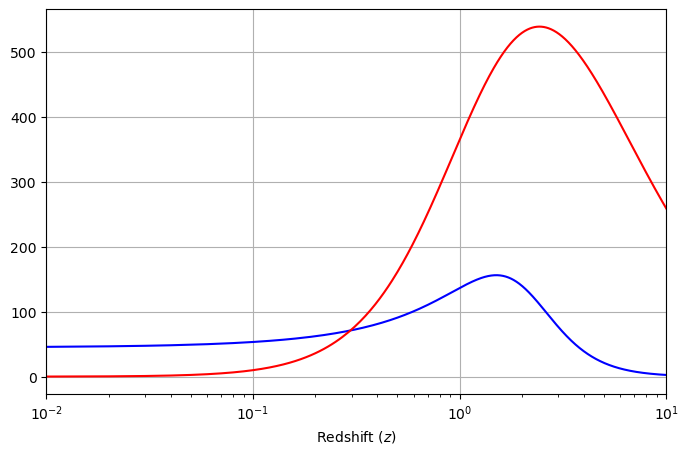

In [8]:

z_values = np.linspace(0, 10, 1000)
#print(z_values)

plt.figure(figsize=(8, 5))
plt.plot(z_values, merger_rate_density(z_values), color='blue')
plt.plot(z_values, differential_comoving_volume_P18(z_values), color='red')


plt.xscale('log')
plt.xlim(10**(-2), 10) 
#plt.ylim(10**(-2), 200) 
plt.xlabel('Redshift ($z$)')
plt.ylabel('')
plt.title('')
plt.grid(True)
plt.show()

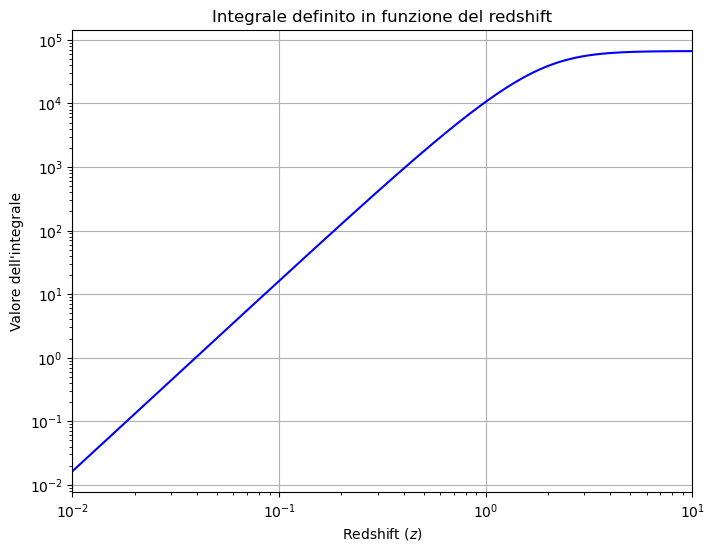

In [10]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(z_values, merger_rate_cumulative(0,10)[0], color='blue')
plt.xscale('log')  # Scala logaritmica sull'asse x
plt.yscale('log')  # Scala logaritmica sull'asse y
plt.xlim(0.01, 10) 
plt.xlabel('Redshift ($z$)')
plt.ylabel('Valore dell\'integrale')
plt.title('Integrale definito in funzione del redshift')
plt.grid(True)
plt.show()

#### Merger rate in linear scale

Z values: [ 0.          0.34482759  0.68965517  1.03448276  1.37931034  1.72413793
  2.06896552  2.4137931   2.75862069  3.10344828  3.44827586  3.79310345
  4.13793103  4.48275862  4.82758621  5.17241379  5.51724138  5.86206897
  6.20689655  6.55172414  6.89655172  7.24137931  7.5862069   7.93103448
  8.27586207  8.62068966  8.96551724  9.31034483  9.65517241 10.        ]
Events rates per shell: [    0.           616.82427659  3582.66702558  7284.33300185
  9763.6264619  10216.88179431  9017.08817799  7107.26951527
  5243.74865106  3747.37361983  2650.61540848  1878.64274404
  1342.80969496   970.91595122   710.98372049   527.3877585
   396.1424917    301.14412304   231.52823783   179.90087647
   141.17612605   111.81537073    89.32772067    71.93953436
    58.37373146    47.70087663    39.23759885    32.47654282
    27.03754521    22.63324898]
[0.34482759 0.34482759 0.34482759 0.34482759 0.34482759 0.34482759
 0.34482759 0.34482759 0.34482759 0.34482759 0.34482759 0.34482759
 0.34482

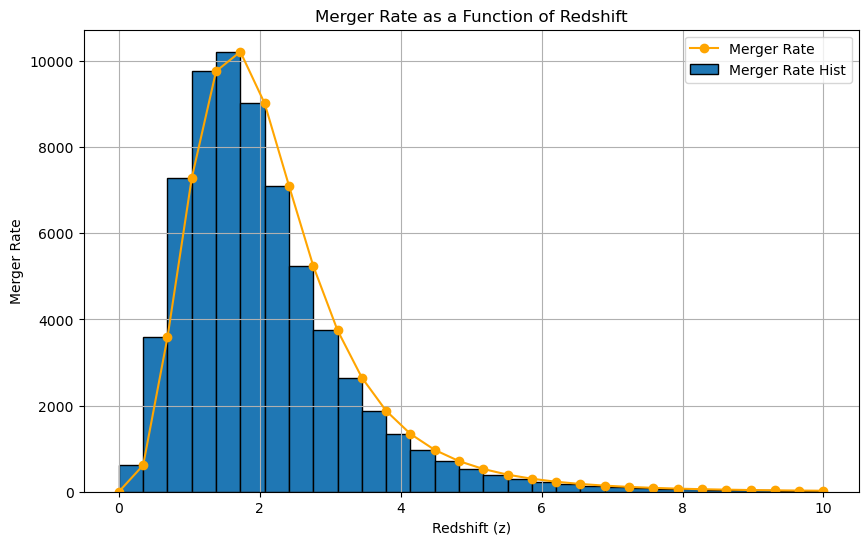

In [33]:
# Definire la griglia di redshift

z_values = np.linspace(0, 10, 30)
#z_values=np.logspace(-1, 1, 29, base=10.0)
#z_values = np.insert(z_values, 0, 0)
print("Z values:",z_values)

rates = []
rates_errors=[]

#Calcolare il tasso di merger per ciascun intervallo di redshift nella griglia
for i in range(0, len(z_values)-1):
    z_min = z_values[i]
    z_max = z_values[i+1]
    rate_value, rate_error = merger_rate(z_min, z_max)
    rates.append(rate_value)
    rates_errors.append(rate_error)

#z_values = np.insert(z_values, 0, 0)
rates = np.insert(rates, 0, 0)  # Aggiungi un tasso di merger zero per z=0
rates_errors = np.insert(rates_errors, 0, 0)

print("Events rates per shell:",rates)

bins = z_values
bin_widths = bins[1:] - bins[:-1] 
bin_centers = (bins[:-1] + bins[1:]) / 2 


# Creare il grafico
plt.figure(figsize=(10, 6))


plt.plot(z_values, rates, color='orange', label='Merger Rate',marker='o')

plt.bar(bin_centers, rates[1:], width=bin_widths, edgecolor='black', label='Merger Rate Hist', align='center')
#plt.hist(bins[:-1], bins=bins, weights=rates[:-1], edgecolor='black', label='Merger Rate Hist', align='mid',color='green')

plt.xlabel('Redshift (z)')
plt.ylabel('Merger Rate')
plt.title('Merger Rate as a Function of Redshift')
plt.legend()
plt.grid(True)
plt.show()



#### Merger rate in log scale

Z values: [ 0.          0.01        0.01279802  0.01637894  0.0209618   0.02682696
  0.0343332   0.04393971  0.05623413  0.07196857  0.09210553  0.11787686
  0.15085907  0.19306977  0.24709112  0.31622777  0.404709    0.51794747
  0.66287032  0.8483429   1.08571112  1.38949549  1.77827941  2.27584593
  2.91263265  3.72759372  4.7705827   6.1054023   7.81370738 10.        ]
Events rates per shell: [0.00000000e+00 1.63797682e-02 1.79443972e-02 3.75957479e-02
 7.87547093e-02 1.64935948e-01 3.45315742e-01 7.22642316e-01
 1.51130985e+00 3.15779301e+00 6.58915231e+00 1.37218903e+01
 2.84917483e+01 5.89001950e+01 1.20967129e+02 2.46025178e+02
 4.93193560e+02 9.67913636e+02 1.84158975e+03 3.34855128e+03
 5.69180826e+03 8.72894388e+03 1.14364696e+04 1.19940787e+04
 9.68281973e+03 6.13336381e+03 3.23113330e+03 1.49727643e+03
 6.33467137e+02 2.50244788e+02]


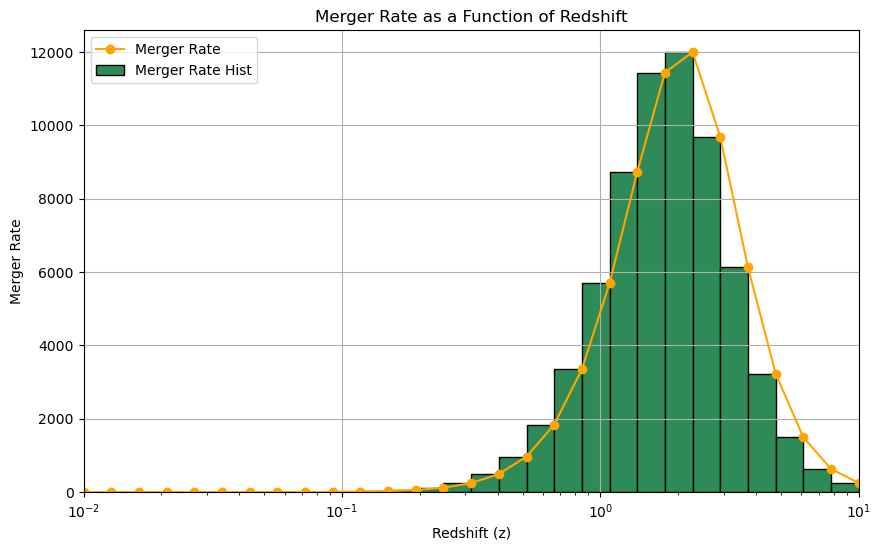

In [24]:
# Definire la griglia di redshift

#z_values = np.linspace(0, 10, 30)
z_values=np.logspace(-2, 1, 29, base=10.0)
z_values = np.insert(z_values, 0, 0)
print("Z values:",z_values)

rates = []
rates_errors=[]

#Calcolare il tasso di merger per ciascun intervallo di redshift nella griglia
for i in range(0, len(z_values)-1):
    z_min = z_values[i]
    z_max = z_values[i+1]
    rate_value, rate_error = merger_rate(z_min, z_max)
    rates.append(rate_value)
    rates_errors.append(rate_error)

#z_values = np.insert(z_values, 0, 0)
rates = np.insert(rates, 0, 0)  # Aggiungi un tasso di merger zero per z=0
rates_errors = np.insert(rates_errors, 0, 0)

print("Events rates per shell:",rates)

bins = z_values
bin_widths = bins[1:] - bins[:-1] 
bin_centers = (bins[:-1] + bins[1:]) / 2 

# Creare il grafico
plt.figure(figsize=(10, 6))


plt.plot(z_values, rates, color='orange', label='Merger Rate',marker='o')

plt.bar(bin_centers, rates[1:], width=bin_widths, edgecolor='black', label='Merger Rate Hist', align='center', color='seagreen')
#plt.hist(bins[:-1], bins=bins, weights=rates[:-1], edgecolor='black', label='Merger Rate Hist', align='mid',color='green')

plt.xlim(10e-3,10)
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Merger Rate')
plt.title('Merger Rate as a Function of Redshift')
plt.legend()
plt.grid(True)
plt.show()


## 2) Event count for every schell

Number of events per shell:[0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 7, 12, 37, 71, 148, 255, 504, 945, 1836, 3284, 5711, 8766, 11500, 12096, 9770, 6058, 3236, 1467, 619, 288]
30


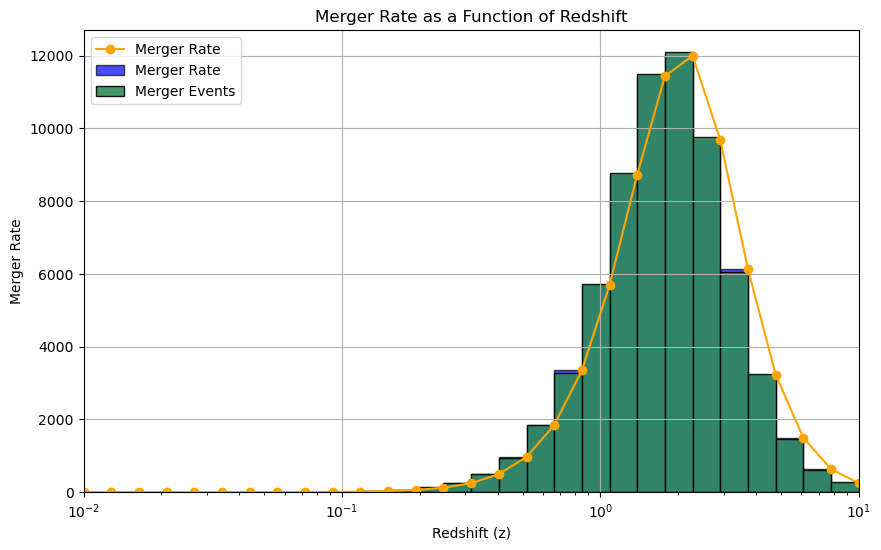

In [26]:

expected_events_per_shell=rates
expected_events_per_shell_errors=rates_errors


# Calcolo del numero possibile di eventi interi per ogni shell
eventi_possibili_per_shell = [np.random.poisson(expected_events) for expected_events in expected_events_per_shell]
print(f"Number of events per shell:{eventi_possibili_per_shell}")
print(len(eventi_possibili_per_shell))

#---------------------------------------------------------------------------------------------------------------------------
bins = z_values
bin_widths = bins[1:] - bins[:-1] 
bin_centers = (bins[:-1] + bins[1:]) / 2 

# Creare il grafico
plt.figure(figsize=(10, 6))


plt.plot(z_values, rates, color='orange', label='Merger Rate',marker='o')

plt.bar(bin_centers, rates[1:], width=bin_widths, edgecolor='black', label='Merger Rate', align='center', color='blue',alpha=0.7)
plt.bar(bin_centers, eventi_possibili_per_shell[1:], width=bin_widths, edgecolor='black', label='Merger Events', align='center', color='seagreen',alpha=0.9)
#plt.hist(bins[:-1], bins=bins, weights=rates[:-1], edgecolor='black', label='Merger Rate Hist', align='mid',color='green')

plt.xlim(10e-3,10)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Merger Rate')
plt.title('Merger Rate as a Function of Redshift')
plt.legend()
plt.grid(True)
plt.show()

## 3) Mass distribution functions
( we used truncated Normal distributions for both BH and NS )

In [16]:

from scipy.stats import norm
from scipy.stats import truncnorm

def truncated_normal(mean, std_dev, lower_bound, upper_bound, size):
    a = (lower_bound - mean) / std_dev
    b = (upper_bound - mean) / std_dev
    return truncnorm.rvs(a, b, loc=mean, scale=std_dev, size=size)

# BH mass distribution parameters 
BH_mean = 15
BH_std_dev = 10
BH_lower_bound = 3.5
BH_upper_bound = 55

# NS mass distribution parameters 
NS_mean = 1.4
NS_std_dev = 0.3
NS_lower_bound = 1.1
NS_upper_bound = 2.1

### Plot

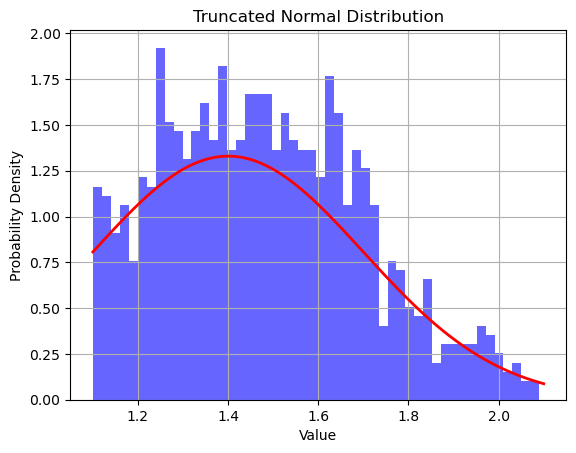

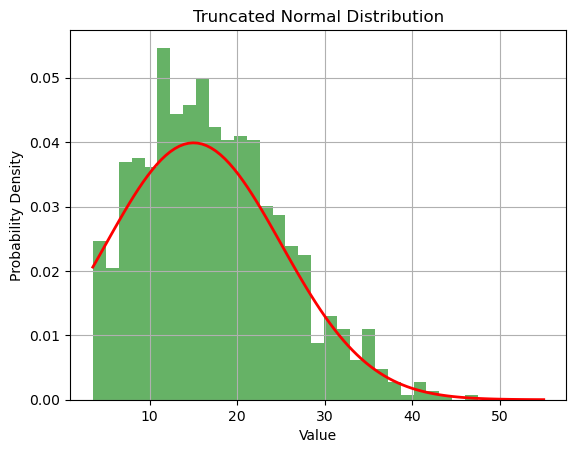

In [17]:

NS_samples = truncated_normal(NS_mean, NS_std_dev, NS_lower_bound, NS_upper_bound,1000)

plt.hist(NS_samples, bins=50, density=True, alpha=0.6, color='b')
x_NS = np.linspace(NS_lower_bound, NS_upper_bound, 100)

plt.plot(x_NS, norm.pdf(x_NS, NS_mean, NS_std_dev), 'r-', lw=2)

plt.title('Truncated Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

#------------------------------------------------------------------------------------------------------------

BH_samples = truncated_normal(BH_mean, BH_std_dev, BH_lower_bound, BH_upper_bound,1000)
plt.hist(BH_samples, bins=30, density=True, alpha=0.6, color='g')

x_BH = np.linspace(BH_lower_bound, BH_upper_bound, 100)
plt.plot(x_BH, norm.pdf(x_BH, BH_mean, BH_std_dev), 'r-', lw=2)

plt.title('Truncated Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

## 4) Event count for every z shell 

Z values: [ 0.          0.01        0.01279802  0.01637894  0.0209618   0.02682696
  0.0343332   0.04393971  0.05623413  0.07196857  0.09210553  0.11787686
  0.15085907  0.19306977  0.24709112  0.31622777  0.404709    0.51794747
  0.66287032  0.8483429   1.08571112  1.38949549  1.77827941  2.27584593
  2.91263265  3.72759372  4.7705827   6.1054023   7.81370738 10.        ]
 Expected events per shell array:[0.00000000e+00 1.63797682e-02 3.43241653e-02 7.19199132e-02
 1.50674623e-01 3.15610571e-01 6.60926313e-01 1.38356863e+00
 2.89487848e+00 6.05267150e+00 1.26418238e+01 2.63637141e+01
 5.48554624e+01 1.13755657e+02 2.34722787e+02 4.80747964e+02
 9.73941524e+02 1.94185516e+03 3.78344491e+03 7.13199619e+03
 1.28238044e+04 2.15527483e+04 3.29892179e+04 4.49832966e+04
 5.46661164e+04 6.07994802e+04 6.40306135e+04 6.55278899e+04
 6.61613570e+04 6.64116018e+04]

Number of events per shell:[0, 0, 0, 0, 0, 0, 0, 4, 2, 5, 21, 28, 48, 120, 248, 498, 1069, 2028, 3681, 7207, 12886, 21401, 33018, 4

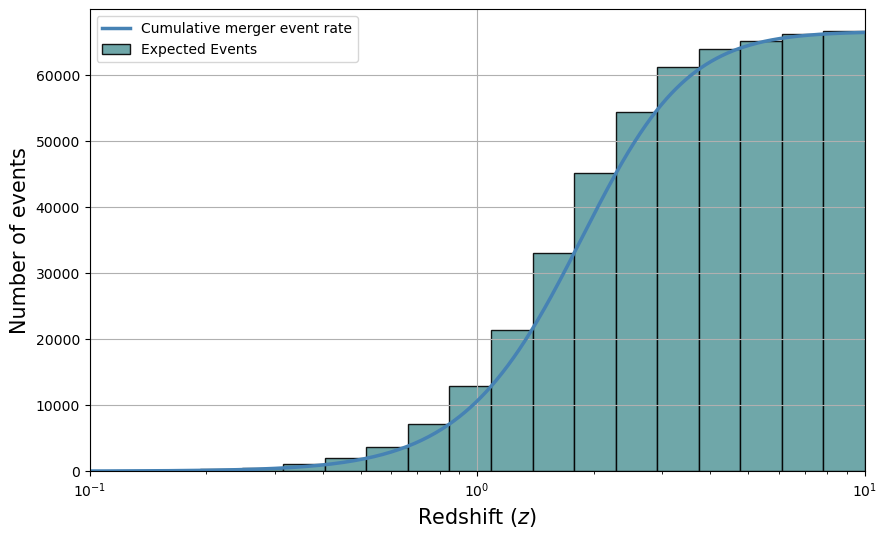

In [39]:
# Definire la griglia di redshift
z_numbers_for_shells=30
min_value = 0.01
max_value = 10

#z_values = np.linspace(min_value, max_value, 30)
z_values=np.logspace(-2, 1, 29, base=10.0)
z_values = np.insert(z_values, 0, 0)
print("Z values:",z_values)

cumulative_rates = []
cumulative_rates_errors=[]

#Calcolare il tasso di merger per ciascun intervallo di redshift nella griglia
for i in range(0, len(z_values)-1):
    z_min = z_values[i]
    z_max = z_values[i+1]
    cumulative_rate_value, cumulative_rate_error = merger_rate(0, z_max)
    cumulative_rates.append(cumulative_rate_value)
    cumulative_rates_errors.append(cumulative_rate_error)

#z_values = np.insert(z_values, 0, 0)
cumulative_rates = np.insert(cumulative_rates, 0, 0)  # Aggiungi un tasso di merger zero per z=0
cumulative_rates_errors = np.insert(cumulative_rates_errors, 0, 0)



#   expected_events_per_shell[i]=merger_rate_cumulative(min,max)[0] # 1/12 stands for 1 month
#    expected_events_per_shell_errors[i]=merger_rate_cumulative(min,max)[1] 

print(f" Expected events per shell array:{cumulative_rates}")
print("")

# Calcolo del numero possibile di eventi interi per ogni shell
eventi_possibili_per_shell = [np.random.poisson(expected_events) for expected_events in cumulative_rates]
print(f"Number of events per shell:{eventi_possibili_per_shell}")
print("")

bins = z_values
bin_widths = bins[1:] - bins[:-1] 
bin_centers = (bins[:-1] + bins[1:]) / 2 

x_values = np.linspace(0, 10, 1000)

plt.figure(figsize=(10, 6))

#plt.hist(z_shells[1:], bins=z_shells, weights=expected_events_per_shell, color='darkcyan', edgecolor='darkgray')
#plt.hist(z_shells[1:], bins=z_shells, weights=eventi_possibili_per_shell, color='cadetblue', edgecolor='black',label="Expected events for z shell")
plt.plot(x_values, merger_rate_cumulative(0,10)[0], color='steelblue', label="Cumulative merger event rate",linewidth=2.5)

plt.bar(bin_centers, eventi_possibili_per_shell[1:], width=bin_widths, edgecolor='black', label='Expected Events', align='center', color='cadetblue',alpha=0.9)
#plt.hist(bins[:-1], bins=bins, weights=rates[:-1], edgecolor='black', label='Merger Rate Hist', align='mid',color='green')

plt.xscale('log')  # Scala logaritmica sull'asse x
#plt.yscale('log')  # Scala logaritmica sull'asse y
plt.xlim(0.1, 10) 
plt.xlabel('Redshift ($z$)',fontsize=15,)
plt.ylabel('Number of events',fontsize=15)
plt.legend()
#plt.title('Integrale definito in funzione del redshift')
plt.grid(True)
plt.show()

## 5.1) Single Population data frame

In [ ]:
#------------------------------------------------- Example for NSBH population -----------------------------------------------------------------

nev =  80 # number of events

dict_single_shell = {}
dict_single_shell['redshift'] = np.random.uniform(0, 1, nev)
dict_single_shell['mass_1'] = truncated_normal(BH_mean, BH_std_dev, BH_lower_bound, BH_upper_bound,nev)
dict_single_shell['mass_2'] = truncated_normal(NS_mean, NS_std_dev, NS_lower_bound, NS_upper_bound,nev)
aux_mass =dict_single_shell['mass_1']
dict_single_shell['mass_1'] = np.maximum(aux_mass, dict_single_shell['mass_2'])
dict_single_shell['mass_2'] = np.minimum(aux_mass, dict_single_shell['mass_2'])
#my_dict['mass_2'] = truncated_normal(NS_mean, NS_std_dev, NS_lower_bound, NS_upper_bound,nev)
#my_dict['mass_2']=np.full(nev,1.4)

dict_single_shell['luminosity_distance'] = Planck18.luminosity_distance(dict_single_shell['redshift']).value
dict_single_shell['theta_jn'] = np.arccos(np.random.uniform(0, 1., nev))
dict_single_shell['ra'] = np.random.uniform(0., 2 * np.pi, nev)
dict_single_shell['dec'] = np.arcsin(np.random.uniform(-1., 1., nev))
dict_single_shell['psi'] = np.random.uniform(0., np.pi, nev)
dict_single_shell['phase'] = np.random.uniform(0., 2 * np.pi, nev)

dict_single_shell['geocent_time'] = np.random.uniform(1388102400.0, 1403740800.0, nev) #from 1 January 2024 to 30 June 2024
dict_single_shell['a_1'] = np.random.uniform(-0.5, 0.75, nev)
dict_single_shell['a_2'] = np.random.uniform(0., 0.05, nev)
dict_single_shell['lambda_1'] = np.full(nev,1)
dict_single_shell['lambda_2'] = np.random.uniform(100., 2000., nev)

#aux_mass = my_dict['mass_1']
#my_dict['mass_1'] = np.maximum(aux_mass, my_dict['mass_2'])
#my_dict['mass_2'] = np.minimum(aux_mass, my_dict['mass_2'])


dict_single_shell = pd.DataFrame(dict_single_shell)

pd.set_option('display.max_rows', None)  # Mostra tutte le righe
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne

display(dict_single_shell)


In [1]:
#network_pop = gw.detection.Network(detector_ids = selected_network_population, detection_SNR = (0., 8.))
network_pop = gw.detection.Network(detector_ids = ['LHO', 'LLO', 'VIR', 'CE1', 'ET'], detection_SNR = (0., 8.))

waveform_model_pop = 'IMRPhenomNSBH'
#waveform_model_pop= 'SEOBNRv4_ROM_NRTidalv2_NSBH'

fisher_parameters_pop = ['redshift','mass_1', 'mass_2', 'luminosity_distance', 'theta_jn','ra','dec',
                         'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'lambda_1', 'lambda_2']


NameError: name 'gw' is not defined

In [ ]:
data_folder_pop = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_sinlge_population'

if not os.path.exists(data_folder_pop):
    os.makedirs(data_folder_pop)
    
    
sub_network_list = [[0, 1, 2], [3, 4], [4]]
gw.fishermatrix.analyze_and_save_to_txt(network = network_pop,
                                            parameter_values  = dict_single_shell,
                                            fisher_parameters = fisher_parameters_pop, 
                                            sub_network_ids_list = sub_network_list,
                                            population_name = 'NSBH',
                                            waveform_model = waveform_model_pop,
                                            save_path = data_folder_pop,
                                            save_matrices = True)


In [35]:
new=network_pop.partial([0, 1,2])
print(new.name)

LHO_LLO_VIR


## 5.2) Multiple redshift (z) schells data frames

In [40]:
print("Z values:", z_values)

Z values: [ 0.          0.01        0.01279802  0.01637894  0.0209618   0.02682696
  0.0343332   0.04393971  0.05623413  0.07196857  0.09210553  0.11787686
  0.15085907  0.19306977  0.24709112  0.31622777  0.404709    0.51794747
  0.66287032  0.8483429   1.08571112  1.38949549  1.77827941  2.27584593
  2.91263265  3.72759372  4.7705827   6.1054023   7.81370738 10.        ]


In [43]:

#tot_nev = 100 # number of events
#normalized_expected_events = (np.array(expected_events_per_shell) /summ_expected_events) * tot_nev

all_dataframes = {}

# z_shells= look above

for i in range(len(z_values)-1):
    
    nev=eventi_possibili_per_shell[i]
    if nev == 0:
        print(f"dataframe_z_{np.round(z_values[i],2)}-{np.round(z_values[i+1],2)} has no expected events")
        #continue  # jump to the next iteration 
    else:
        
        dict_multiple_shell = {}
        dict_multiple_shell['redshift'] = np.random.uniform(z_values[i], z_values[i+1], nev)
        
        dict_multiple_shell['mass_1'] = truncated_normal(BH_mean, BH_std_dev, BH_lower_bound, BH_upper_bound,nev)
        dict_multiple_shell['mass_2'] = truncated_normal(NS_mean, NS_std_dev, NS_lower_bound, NS_upper_bound,nev)
        #dict_multiple_shell['mass_2'] =np.full(nev,1.4)
        
        dict_multiple_shell['luminosity_distance'] = Planck18.luminosity_distance(dict_multiple_shell['redshift']).value
        
        dict_multiple_shell['theta_jn'] = np.arccos(np.random.uniform(0, 1., nev))
        dict_multiple_shell['ra'] = np.random.uniform(0., 2 * np.pi, nev)
        dict_multiple_shell['dec'] = np.arcsin(np.random.uniform(-1., 1., nev))
        dict_multiple_shell['psi'] = np.random.uniform(0., np.pi, nev)
        dict_multiple_shell['phase'] = np.random.uniform(0., 2 * np.pi, nev)

        dict_multiple_shell['geocent_time'] = np.random.uniform(t_start, t_finish, nev) # last 6 months 
        dict_multiple_shell['a_1'] = np.random.uniform(-0.5, 0.9, nev)
        dict_multiple_shell['a_2'] = np.random.uniform(0., 0.05, nev)
        dict_multiple_shell['lambda_1'] = np.full(nev,1)
        dict_multiple_shell['lambda_2'] = np.random.uniform(100., 2999., nev)

        #aux_mass = my_dict['mass_1']
        #my_dict['mass_1'] = np.maximum(aux_mass, my_dict['mass_2'])
        #my_dict['mass_2'] = np.minimum(aux_mass, my_dict['mass_2'])


        dict_multiple_shell = pd.DataFrame(dict_multiple_shell)
        #display(my_dict)
            
        dataframe_name = f"dataframe_z_{np.round(z_values[i],2)}-{np.round(z_values[i+1],2)}"  # Puoi usare qualsiasi schema di denominazione desiderato

        all_dataframes[dataframe_name] = dict_multiple_shell

for name, dataframe in all_dataframes.items():
    
    #print(f"{name}:\n{dataframe}\n")
    print(f"Fisher matrix coputation of Dataframe:{name}")
    display(dataframe)

    

dataframe_z_0.0-0.01 has no expected events
dataframe_z_0.01-0.01 has no expected events
dataframe_z_0.01-0.02 has no expected events
dataframe_z_0.02-0.02 has no expected events
dataframe_z_0.02-0.03 has no expected events
dataframe_z_0.03-0.03 has no expected events
dataframe_z_0.03-0.04 has no expected events
Fisher matrix coputation of Dataframe:dataframe_z_0.04-0.06


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0  0.050577  12.522588  2.040722           232.628049  0.875521  5.200772   
1  0.050246  26.256182  1.276492           231.052414  0.600753  2.280537   
2  0.055275   4.248623  1.558582           255.085263  0.851096  3.725711   
3  0.053823  22.768766  2.092455           248.128460  0.315687  1.045452   

        dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0 -0.670660  0.778982  4.889259  1.390009e+09  0.249713  0.013534         1   
1  0.689527  2.509686  0.425739  1.406252e+09 -0.203617  0.007757         1   
2  1.321809  0.446956  0.506754  1.400805e+09  0.733448  0.002046         1   
3  0.380358  0.722218  4.258942  1.390871e+09 -0.350710  0.031984         1   

      lambda_2  
0   673.219652  
1   369.926079  
2  1134.712950  
3   743.300974

Fisher matrix coputation of Dataframe:dataframe_z_0.06-0.07


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0  0.062769  13.280026  1.606203           291.199188  1.149988  5.404036   
1  0.068147  19.602734  1.973596           317.333839  1.295067  0.142891   

        dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0 -0.543205  2.801828  5.000799  1.404252e+09 -0.008015  0.035533         1   
1  0.877794  0.479148  0.889376  1.416651e+09  0.525506  0.028209         1   

      lambda_2  
0   491.777948  
1  2836.472147

Fisher matrix coputation of Dataframe:dataframe_z_0.07-0.09


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0  0.087824  11.419294  1.822951           414.499221  0.617949  3.397239   
1  0.083509  15.966895  1.473350           392.984572  1.271403  0.917795   
2  0.077096   7.000030  1.114615           361.225154  1.407189  0.295524   
3  0.081745   9.297079  1.322790           384.226645  1.564183  2.861775   
4  0.089266   4.982437  1.334208           421.716067  0.775345  4.849022   

        dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0  0.956291  0.398719  4.939634  1.406235e+09 -0.101447  0.030709         1   
1 -0.179752  2.030342  2.782008  1.415637e+09 -0.298027  0.031635         1   
2  0.981673  2.152648  0.877856  1.389615e+09 -0.247437  0.013102         1   
3  0.701832  0.913280  6.021431  1.414180e+09  0.526057  0.042462         1   
4 -0.817213  1.765447  0.786996  1.415756e+09  0.560699  0.027588         1   

      lambda_2  
0  2702.395076  
1  2912.988290  
2   938.064680  
3  2221.919048  
4   814.899541

Fisher matrix coputation of Dataframe:dataframe_z_0.09-0.12


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0   0.106586   9.991473  1.259091           509.365761  0.616659  1.918415   
1   0.107028  18.717304  1.743836           511.626863  1.325842  5.990660   
2   0.100915   8.249166  1.502040           480.466015  0.714231  5.360843   
3   0.106205   8.471056  1.349099           507.418202  0.574292  3.086128   
4   0.116852  30.334871  1.338737           562.171541  0.685717  1.375303   
5   0.102116  15.433393  1.606093           486.569183  1.545262  5.358644   
6   0.106267  36.508479  1.580181           507.738217  1.314608  3.546673   
7   0.109904  11.610757  1.760721           526.366706  1.229062  2.325136   
8   0.111570  17.363084  1.640061           534.924851  0.873674  2.344967   
9   0.095725  26.328150  1.248654           454.186786  0.999296  1.606073   
10  0.110052  19.570850  1.572642           527.123379  1.145796  1.058033   
11  0.101602  16.679023  1.133561           483.955741  0.158455  0.427840   
12  0.113916  28.209694  1.301523           547.005040  0.255063  0.976357   
13  0.112008  14.077422  1.408270           537.177674  1.526674  3.993341   
14  0.101637  15.638468  1.381519           484.135618  0.879348  0.209977   
15  0.109779  22.316209  1.853447           525.723660  1.143982  1.971720   
16  0.107502  14.548715  1.677232           514.050741  1.389031  0.708596   
17  0.099788  22.872726  1.654314           474.748621  0.572592  1.598627   
18  0.097802  10.085317  1.232231           464.686065  0.926652  4.435785   
19  0.115606   4.574129  1.634761           555.732556  1.423629  5.241558   
20  0.098925  21.934906  1.499243           470.370019  1.425158  3.782836   

         dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0  -0.668615  1.516711  5.470936  1.392435e+09  0.064852  0.005474         1   
1  -0.167045  0.501809  5.082518  1.391599e+09  0.832734  0.035694         1   
2  -0.699693  1.848963  5.219019  1.411702e+09  0.206955  0.033217         1   
3  -0.116661  0.566820  0.444926  1.398137e+09  0.021843  0.016351         1   
4   0.922555  1.129005  2.233608  1.414802e+09  0.163160  0.013463         1   
5  -0.288443  0.311754  5.693765  1.417958e+09  0.243017  0.035309         1   
6  -1.360222  2.940239  3.271650  1.398126e+09  0.642252  0.039390         1   
7   0.713356  0.534911  4.807136  1.406675e+09  0.835671  0.018845         1   
8  -0.598797  2.040488  0.665167  1.416595e+09  0.407679  0.022006         1   
9  -0.801653  1.666701  0.693291  1.403172e+09  0.683192  0.028312         1   
10 -0.175561  0.938820  3.567882  1.398964e+09 -0.491183  0.013369         1   
11 -1.448508  2.853009  5.931124  1.397968e+09  0.061023  0.047810         1   
12  0.587774  0.955479  3.886224  1.395887e+09  0.424355  0.020666         1   
13 -0.423922  0.263434  5.567089  1.398103e+09  0.762943  0.010579         1   
14  1.019196  3.038985  4.548129  1.396604e+09  0.553343  0.033125         1   
15  0.034963  2.557702  0.141444  1.418833e+09  0.479531  0.022016         1   
16 -1.054539  1.214659  1.937080  1.402800e+09 -0.429376  0.037029         1   
17  0.426871  2.268984  2.722588  1.418597e+09  0.220366  0.018644         1   
18 -0.700059  2.358565  5.348618  1.388459e+09 -0.357427  0.001104         1   
19 -0.447414  0.822408  3.008426  1.403665e+09 -0.406690  0.018976         1   
20  0.634989  1.072546  3.897472  1.389651e+09  0.225265  0.033057         1   

       lambda_2  
0    894.551999  
1    561.489805  
2   2301.331419  
3   1353.040135  
4   1535.662146  
5   1421.258148  
6   1977.182223  
7   1024.347619  
8   1916.806472  
9   2882.476713  
10  2642.145652  
11   465.683269  
12  2834.215580  
13  2115.651821  
14   520.562558  
15  2040.063101  
16  1726.076820  
17   589.298999  
18  2386.511426  
19  1799.401832  
20  1960.616453

Fisher matrix coputation of Dataframe:dataframe_z_0.12-0.15


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0   0.127225  23.113029  1.290839           616.164992  0.672700  3.414592   
1   0.148581  27.846776  1.586646           729.308334  1.552992  3.729614   
2   0.148879   7.599845  1.353786           730.903519  0.743864  6.281774   
3   0.148150  15.384276  1.769036           726.998760  1.536886  0.285960   
4   0.132852  23.183266  1.640115           645.722525  0.955994  1.973236   
5   0.130980  33.031867  1.493956           635.868632  0.763285  2.547839   
6   0.135081  20.125258  1.372835           657.480857  0.185010  2.897596   
7   0.124529  20.656536  1.358315           602.070419  0.914286  5.962603   
8   0.125298  14.504380  1.609020           606.086891  1.185938  4.528785   
9   0.125469   7.929250  1.746782           606.980969  1.410246  1.730787   
10  0.124650  11.901327  1.648674           602.703735  1.237808  4.884095   
11  0.148308  18.352525  1.601234           727.843537  0.448474  0.730974   
12  0.122201  10.197438  1.343901           589.934914  1.532646  1.044775   
13  0.118568  15.308097  1.691531           571.061713  1.245388  2.720512   
14  0.125108  10.165726  1.180329           605.096464  1.321573  3.532356   
15  0.142124  10.259657  1.691342           694.821447  1.443276  0.919932   
16  0.137618  22.431125  1.296637           670.899886  0.191784  1.062413   
17  0.150035  13.053453  1.522453           737.109028  1.028547  5.900334   
18  0.149512   8.343050  1.593912           734.301936  1.557859  3.197889   
19  0.126047   6.932378  1.215574           610.002612  1.342380  1.085999   
20  0.120101   7.372257  1.332757           579.018656  1.247709  3.169154   
21  0.127613  24.357614  1.148507           618.199932  1.358825  1.669522   
22  0.118953  11.411507  1.634448           573.059384  0.954902  6.252798   
23  0.135467   8.765291  1.310951           659.516924  1.545302  5.804357   
24  0.126905  26.259371  1.557131           614.492819  1.162783  5.931179   
25  0.125323  16.470039  1.513591           606.218270  1.118578  2.325818   
26  0.147115  43.212180  1.792166           721.455603  1.261910  2.077910   
27  0.119189  26.149614  1.203771           574.282074  0.546711  0.371588   

         dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0  -0.265947  2.873849  4.982536  1.400321e+09 -0.424464  0.010921         1   
1   0.175323  0.136434  0.133197  1.402885e+09  0.362782  0.021292         1   
2  -0.601963  1.251605  5.230200  1.397295e+09 -0.136687  0.007448         1   
3  -1.353126  0.496671  2.430328  1.389595e+09  0.783128  0.019039         1   
4   0.843246  1.846770  6.242420  1.404051e+09 -0.397345  0.027028         1   
5  -1.472067  3.137358  6.017496  1.388895e+09 -0.342353  0.040745         1   
6   1.523866  1.496066  5.871357  1.399184e+09  0.848893  0.033543         1   
7  -0.188909  1.581608  4.447753  1.400355e+09  0.191971  0.013528         1   
8  -0.409411  0.179798  2.562252  1.391101e+09  0.447060  0.041737         1   
9   0.095310  0.300481  1.560775  1.416275e+09 -0.343315  0.037797         1   
10  0.547470  1.093995  1.949368  1.405239e+09  0.490017  0.037711         1   
11 -0.181778  1.697499  2.545398  1.396636e+09  0.383692  0.021412         1   
12 -0.299209  0.023591  2.382404  1.413104e+09 -0.153738  0.005980         1   
13 -1.445270  0.648720  3.599937  1.400141e+09 -0.186576  0.004497         1   
14  0.855121  2.982455  4.217075  1.413227e+09  0.310829  0.016174         1   
15  0.660352  2.372400  5.192825  1.391443e+09 -0.006847  0.007136         1   
16  1.070268  2.087877  0.124415  1.415451e+09  0.678709  0.003886         1   
17 -0.049110  0.698513  2.661202  1.411928e+09 -0.442165  0.020432         1   
18  0.101246  1.930302  0.644586  1.395520e+09  0.661749  0.041595         1   
19  0.594137  2.693224  5.342441  1.391930e+09  0.377765  0.005503         1   
20 -0.489513  2.659455  6.065731  1.413478e+09  0.480989  0.0

Fisher matrix coputation of Dataframe:dataframe_z_0.15-0.19


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0   0.174096  15.821229  1.164634           867.896994  1.273633  3.212357   
1   0.183627  12.887620  1.530625           920.600662  1.241618  4.179844   
2   0.182468  22.893945  1.667957           914.165341  1.061629  5.942445   
3   0.162178  23.341032  1.567007           802.704838  0.929028  4.011850   
4   0.184367  18.120470  1.232472           924.715243  1.382500  0.023477   
5   0.162921  30.931205  1.816214           806.746078  0.687570  6.229002   
6   0.187819   7.810590  1.288256           943.939939  0.868204  0.272978   
7   0.180059  11.915156  1.856529           900.814892  1.271859  1.406373   
8   0.179883   5.845263  1.659174           899.838576  0.757966  1.441890   
9   0.164003  20.635105  1.218249           812.640649  0.258274  1.003278   
10  0.176095  21.909158  1.202897           878.910865  1.107984  2.297845   
11  0.168188  12.890822  1.261733           835.482230  1.459755  0.551830   
12  0.167999  17.124891  1.263688           834.447157  1.546010  2.350210   
13  0.160708  12.269067  1.220348           794.721259  1.394503  4.450385   
14  0.183868  19.348070  1.578650           921.938326  1.372223  2.402937   
15  0.161010   8.675366  1.380222           796.363065  1.509899  6.257469   
16  0.157613   6.312797  1.374988           777.949199  0.129994  6.198592   
17  0.179842  23.157059  1.225244           899.612605  1.314727  1.668771   
18  0.156238   6.868330  1.711091           770.514655  1.074541  4.415087   
19  0.184613  13.875710  1.690599           926.080427  1.215420  6.151234   
20  0.157987  13.937932  1.365338           779.969958  1.527799  0.272262   
21  0.186159   4.507797  1.457163           934.682717  1.199100  0.643917   
22  0.190090  25.883871  1.407158           956.622962  0.960124  4.373479   
23  0.151834  17.328446  1.695657           746.774888  1.466521  3.484339   
24  0.168419   8.867048  1.404452           836.748190  0.436233  2.821623   
25  0.187404   9.187809  1.630525           941.621123  0.376175  0.993057   
26  0.176526   5.233300  1.655788           881.285680  0.746808  1.106164   
27  0.182489  11.905438  1.615475           914.281590  1.505722  4.593294   
28  0.151534  12.583017  1.221135           745.157705  1.449598  1.782620   
29  0.167476  25.962333  1.107126           831.588727  0.761924  5.400271   
30  0.167496  19.110793  1.249136           831.698812  1.361475  3.523251   
31  0.159323  17.531137  1.599643           787.210428  1.116276  3.027872   
32  0.166968  22.173282  1.246850           828.815977  0.953858  1.397136   
33  0.153984   9.506952  1.176396           758.347786  1.414906  3.160399   
34  0.157102  14.521585  1.848208           775.183065  0.691343  4.509890   
35  0.163879  21.791925  1.246046           811.965146  0.783082  1.053723   
36  0.188838  15.887245  1.299510           949.627414  0.961272  3.763079   
37  0.156200  17.350641  1.726050           770.309741  1.514887  0.664377   
38  0.181200  22.057223  1.259295           907.130523  0.206709  6.220950   
39  0.162345  14.264790  1.586763           803.616131  1.387810  1.940424   
40  0.166517  12.923391  1.459840           826.348032  0.840254  2.680724   
41  0.159109  26.313993  1.440429           786.050587  1.252555  2.182905   
42  0.170982  12.952438  1.162048           850.787431  0.283220  2.175761   
43  0.189695  19.052678  1.256480           954.414864  0.561958  5.555210   
44  0.168879  24.544409  1.577511           839.263327  1.077605  0.994250   
45  0.171462  24.270852  1.825767           853.421452  1.087929  4.700116   
46  0.161046   9.141996  1.660953           796.559257  0.548730  4.227315   
47  0.168910  11.731618  1.674532           839.434296  1.135675  1.688174   

         dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0   0.590831  0.870764  4.252445  1.419288e+09 -0.496894  0.026626         1   
1   0.646602  0.61577

Fisher matrix coputation of Dataframe:dataframe_z_0.19-0.25


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0    0.198819   6.873335  1.321209          1005.628759  0.869057  1.743293   
1    0.203452  26.973443  1.241675          1031.809397  1.411432  3.928583   
2    0.213539   9.922573  1.135353          1089.202213  1.345303  2.960506   
3    0.236113  18.076141  1.313043          1219.585788  1.233203  3.825350   
4    0.208088  16.424308  1.383614          1058.124307  1.324723  0.460768   
..        ...        ...       ...                  ...       ...       ...   
115  0.211424  19.955924  1.478674          1077.126461  0.341247  4.612030   
116  0.232265   5.900140  1.131120          1197.171211  1.008490  1.386794   
117  0.197140  13.846122  1.466603           996.172176  1.129626  4.108660   
118  0.205589   9.498806  1.553092          1043.926685  0.923608  5.077568   
119  0.201976  12.265166  1.262952          1023.456093  0.766651  5.444766   

          dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0   -0.754508  1.849633  1.435979  1.395628e+09  0.440473  0.039446         1   
1    0.260015  1.243442  3.657294  1.396711e+09  0.358698  0.004433         1   
2   -0.233010  0.719312  4.316762  1.413543e+09  0.224668  0.035608         1   
3    0.146919  2.032037  5.386862  1.403208e+09 -0.270772  0.026847         1   
4   -0.100534  0.115153  3.037674  1.390423e+09 -0.171122  0.045787         1   
..        ...       ...       ...           ...       ...       ...       ...   
115  0.228765  0.930311  5.212933  1.402696e+09 -0.246609  0.027248         1   
116 -0.558666  2.103221  4.012777  1.415190e+09  0.492294  0.002098         1   
117 -0.821992  0.091596  4.747326  1.398018e+09  0.206367  0.028144         1   
118 -0.591778  1.036895  1.339699  1.396036e+09  0.226209  0.042226         1   
119 -0.032307  0.881935  4.755065  1.414511e+09 -0.070523  0.049517         1   

        lambda_2  
0    1809.628168  
1     517.631038  
2     605.174467  
3     321.186103  
4    2515.843476  
..           ...  
115  2294.009240  
116  2299.018919  
117  2812.022591  
118   534.123396  
119  2201.961857  

[120 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_0.25-0.32


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0    0.293590  17.719129  1.909526          1563.200405  1.063205  3.760337   
1    0.270368   4.428962  1.430780          1422.403649  0.558342  3.800496   
2    0.310426   8.480357  1.728406          1666.887708  0.582455  5.024893   
3    0.301316  10.425595  1.234028          1610.616989  0.481803  1.240256   
4    0.306740  20.598727  1.377914          1644.074606  1.048662  2.920493   
..        ...        ...       ...                  ...       ...       ...   
243  0.250980  20.166556  1.977711          1306.883290  1.219068  2.984222   
244  0.268186  13.769717  1.583072          1409.310007  1.107831  1.850282   
245  0.259047  35.538675  1.487112          1354.726001  1.036732  5.530938   
246  0.307887  16.629602  1.670836          1651.168517  0.543135  3.858650   
247  0.291075  15.034864  1.335315          1547.824668  0.966355  5.681710   

          dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0    0.093288  0.105945  2.075841  1.415427e+09  0.420290  0.030844         1   
1   -1.211532  1.684528  0.399092  1.415975e+09  0.564352  0.025346         1   
2   -0.964982  0.877639  6.253984  1.402827e+09  0.844013  0.011885         1   
3    0.126161  2.353250  3.221514  1.389951e+09 -0.253815  0.019247         1   
4    0.957800  1.464180  5.791053  1.402054e+09 -0.459593  0.013935         1   
..        ...       ...       ...           ...       ...       ...       ...   
243  0.230694  0.887430  1.938806  1.391216e+09 -0.466521  0.044567         1   
244  0.991637  2.336340  2.497478  1.409552e+09 -0.485897  0.018522         1   
245  0.847180  0.371100  1.086040  1.418329e+09  0.750647  0.028777         1   
246 -1.235451  0.995441  4.429778  1.403309e+09 -0.411776  0.019388         1   
247  0.969825  1.115638  3.629572  1.400289e+09 -0.123777  0.021413         1   

        lambda_2  
0    1927.786774  
1    2315.538467  
2    1485.805129  
3    2682.552127  
4     351.260071  
..           ...  
243  1299.155801  
244  2477.771615  
245  1064.987262  
246  1529.086477  
247  1372.032498  

[248 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_0.32-0.4


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0    0.397688  17.209387  1.543072          2224.941996  0.810118  5.269678   
1    0.357161   9.090379  1.478084          1961.583668  1.002805  2.289959   
2    0.380151  20.249263  1.844917          2110.117649  0.933247  4.485953   
3    0.373068   7.799196  1.546207          2064.108714  1.436539  3.719442   
4    0.386559  15.374663  1.347819          2151.926649  1.091587  2.052618   
..        ...        ...       ...                  ...       ...       ...   
493  0.404305  23.445328  1.663765          2268.604405  1.119708  4.400122   
494  0.327172  17.410045  1.360661          1771.342581  1.262830  1.611603   
495  0.357539   8.874802  1.404729          1964.007655  0.836919  2.358552   
496  0.366601  11.552205  1.906340          2022.295102  0.916960  2.692593   
497  0.399986  23.192126  1.598560          2240.085522  1.043317  5.711755   

          dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0   -0.421780  0.227560  0.328567  1.403624e+09 -0.093094  0.030003         1   
1   -1.381805  0.910231  3.558808  1.402207e+09  0.399491  0.003478         1   
2   -0.163576  2.463802  2.622924  1.400025e+09 -0.255462  0.006966         1   
3    0.119959  2.941340  4.961241  1.391782e+09 -0.423446  0.001484         1   
4    0.603349  2.811750  2.550899  1.405559e+09  0.640842  0.005736         1   
..        ...       ...       ...           ...       ...       ...       ...   
493 -0.596567  2.973437  5.212333  1.404871e+09  0.317980  0.049236         1   
494  0.342114  2.225429  5.825272  1.397828e+09 -0.140550  0.015418         1   
495 -0.185015  1.365415  0.101648  1.394205e+09 -0.128821  0.017447         1   
496 -1.159123  0.259228  3.231008  1.390638e+09 -0.059068  0.039883         1   
497 -1.220415  0.548963  4.664919  1.390213e+09  0.025633  0.032648         1   

        lambda_2  
0    1231.754858  
1    2638.640176  
2    1829.282537  
3    2691.062641  
4    1322.110394  
..           ...  
493   745.030130  
494   390.532530  
495  2144.936589  
496   548.238914  
497  2487.703637  

[498 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_0.4-0.52


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0     0.446200   7.169972  1.753810          2549.205264  1.266615  2.331427   
1     0.439473   9.068623  1.793203          2503.678288  1.545997  3.990217   
2     0.434885  14.124592  1.660777          2472.724777  1.347204  0.030088   
3     0.459669  18.089160  1.848924          2640.906666  0.396598  0.420237   
4     0.468028  26.577531  1.603510          2698.162579  1.307140  0.782779   
...        ...        ...       ...                  ...       ...       ...   
1064  0.410507  32.417002  1.695667          2309.696952  0.742522  2.565463   
1065  0.497286  14.386892  1.304630          2900.675315  0.627022  0.523470   
1066  0.414925   7.039436  1.778365          2339.063915  0.944433  4.356550   
1067  0.516169  14.363712  1.477568          3033.061881  0.746686  3.796111   
1068  0.443484   3.826767  1.363283          2530.806734  0.766435  3.371785   

           dec       psi     phase  geocent_time       a_1       a_2  \
0     0.257357  2.230027  5.984832  1.403008e+09 -0.109254  0.046530   
1    -0.228723  1.403065  4.630866  1.397852e+09  0.074144  0.041938   
2     0.458918  2.063455  2.091862  1.414763e+09  0.800055  0.015418   
3    -1.007284  0.633393  2.899421  1.407386e+09  0.823515  0.010733   
4     0.110254  2.687329  4.996910  1.400862e+09  0.863066  0.020131   
...        ...       ...       ...           ...       ...       ...   
1064 -0.884638  1.638818  5.679894  1.398793e+09 -0.146093  0.000902   
1065  0.574533  2.629352  0.949676  1.402355e+09  0.740728  0.044787   
1066 -0.142990  0.943901  0.290554  1.407257e+09  0.721252  0.009303   
1067 -0.565161  3.125158  5.383191  1.404735e+09  0.100188  0.047890   
1068 -0.275815  0.445299  5.748834  1.410884e+09  0.063491  0.042090   

      lambda_1     lambda_2  
0            1  2660.897037  
1            1   720.855315  
2            1  1667.483625  
3            1  1602.842687  
4            1   562.010421  
...        ...          ...  
1064         1  2151.219811  
1065         1  2921.446510  
1066         1   120.610462  
1067         1  1800.686178  
1068         1  1700.388005  

[1069 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_0.52-0.66


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0     0.521211  12.704858  1.146247          3068.632332  0.982322  0.896752   
1     0.648108   8.853754  1.208301          3992.281672  0.232090  3.833841   
2     0.588737  18.292394  1.541862          3553.511980  0.797299  1.449197   
3     0.633227  22.974186  1.747161          3881.257863  1.007097  2.302189   
4     0.652822  15.196357  1.415225          4027.585620  0.755053  3.658744   
...        ...        ...       ...                  ...       ...       ...   
2023  0.547201  19.868464  1.565978          3253.395297  0.842835  2.978787   
2024  0.537623  28.023779  1.876056          3185.027576  0.803432  0.065617   
2025  0.654977  30.380974  1.410855          4043.750988  0.667561  3.035274   
2026  0.618111  21.330377  1.492726          3769.192809  1.557913  3.554548   
2027  0.570922  26.664292  1.570441          3424.077689  1.210924  5.478149   

           dec       psi     phase  geocent_time       a_1       a_2  \
0     1.184790  0.775781  4.143597  1.405678e+09 -0.466009  0.013836   
1    -0.328286  3.103759  5.098457  1.408716e+09 -0.338563  0.027275   
2     0.760670  1.633875  4.802043  1.414611e+09  0.323289  0.032328   
3    -0.973638  1.189063  5.530739  1.412149e+09  0.755628  0.013831   
4     0.309000  2.822130  5.239317  1.415835e+09  0.386906  0.016137   
...        ...       ...       ...           ...       ...       ...   
2023 -0.151217  0.430499  4.985294  1.398273e+09  0.217439  0.020985   
2024  0.997656  2.480960  1.878583  1.403945e+09  0.133791  0.010035   
2025  0.135663  1.037709  4.079393  1.418913e+09  0.296910  0.005397   
2026  0.130325  0.038860  2.531444  1.410675e+09  0.281476  0.003061   
2027 -0.622352  0.058853  3.340379  1.398723e+09 -0.090774  0.036506   

      lambda_1     lambda_2  
0            1  2839.847929  
1            1   223.190297  
2            1  1905.707752  
3            1  1905.278030  
4            1  1323.344981  
...        ...          ...  
2023         1  2016.030605  
2024         1  1450.696532  
2025         1   637.985221  
2026         1  2277.361466  
2027         1   380.508492  

[2028 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_0.66-0.85


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0     0.786526   8.793309  1.416410          5055.840869  1.570247  5.134233   
1     0.795016  16.662442  1.610927          5122.786112  0.850337  3.528400   
2     0.716169  14.608719  1.364062          4508.491267  1.296466  4.641030   
3     0.672830  29.041649  1.372340          4178.205103  0.567749  4.535826   
4     0.664886   5.658164  1.277827          4118.258597  1.310111  2.205459   
...        ...        ...       ...                  ...       ...       ...   
3676  0.835662   9.064409  1.189527          5445.789653  1.292000  2.660566   
3677  0.701949  13.629464  1.299433          4399.528188  0.461693  2.578427   
3678  0.762062   6.844445  1.195528          4864.012009  0.395392  5.996784   
3679  0.775995  30.808137  1.100345          4973.072289  1.282764  4.271859   
3680  0.753517  19.615926  1.186168          4797.381182  1.564348  2.817260   

           dec       psi     phase  geocent_time       a_1       a_2  \
0     0.211521  1.618169  0.663957  1.396875e+09  0.312698  0.030657   
1    -0.900241  1.473291  2.426434  1.409974e+09  0.742743  0.041800   
2     0.079670  0.051213  1.222992  1.391478e+09  0.492224  0.009838   
3    -0.626067  0.774523  2.276087  1.396843e+09  0.871851  0.001789   
4    -1.263116  2.391106  3.020756  1.392811e+09 -0.263893  0.007103   
...        ...       ...       ...           ...       ...       ...   
3676  0.203632  1.102523  0.594196  1.396513e+09 -0.407018  0.013985   
3677 -0.772239  1.124856  3.730373  1.404464e+09  0.657796  0.033845   
3678  0.895948  0.178608  0.540347  1.410939e+09  0.205532  0.021264   
3679  0.195096  2.592690  5.756733  1.408347e+09 -0.305421  0.007767   
3680 -0.283206  1.857438  0.547636  1.400262e+09 -0.072475  0.045598   

      lambda_1     lambda_2  
0            1  1760.667122  
1            1  2498.672641  
2            1  2480.423548  
3            1  2525.250190  
4            1  1554.781560  
...        ...          ...  
3676         1  1759.350870  
3677         1  1136.847361  
3678         1  1114.442315  
3679         1  2587.490209  
3680         1  1636.757585  

[3681 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_0.85-1.09


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0     0.867474  36.731546  1.394469          5701.434516  0.990818  3.932567   
1     0.865589  17.287125  1.281947          5686.216404  1.438458  4.786433   
2     0.977368   4.182977  1.443734          6602.453729  1.372729  3.528098   
3     0.863343   6.457043  1.616420          5668.097959  0.027658  1.477610   
4     0.917403  13.086823  1.613273          6107.455796  1.376438  1.577145   
...        ...        ...       ...                  ...       ...       ...   
7202  0.966383  10.234930  1.433148          6511.201347  0.910515  3.837214   
7203  0.928065  19.243768  1.750660          6194.900223  0.804553  1.627730   
7204  1.081302   8.175418  1.396267          7478.030187  0.777407  0.867928   
7205  0.969646  29.710036  1.515835          6538.283542  0.473407  0.324503   
7206  0.980623  10.111054  1.200533          6629.550430  0.899087  3.648893   

           dec       psi     phase  geocent_time       a_1       a_2  \
0    -0.018609  0.706226  0.330526  1.399165e+09  0.142935  0.028929   
1    -0.321203  2.938112  3.062561  1.404019e+09  0.781570  0.022774   
2     0.405511  2.141467  0.059234  1.416623e+09  0.402590  0.049710   
3    -0.199555  1.237471  4.215901  1.390651e+09  0.124149  0.033925   
4    -0.312816  2.599252  2.303443  1.394470e+09  0.257251  0.034356   
...        ...       ...       ...           ...       ...       ...   
7202  0.838874  1.650433  1.161390  1.400217e+09  0.053988  0.014694   
7203 -0.263732  0.410363  0.618872  1.397862e+09  0.489446  0.017122   
7204 -0.328299  2.882973  0.942734  1.401439e+09  0.502089  0.011865   
7205 -0.958219  1.653212  1.116822  1.394888e+09  0.161539  0.045624   
7206 -0.171395  0.803972  4.794232  1.388257e+09  0.367793  0.015562   

      lambda_1     lambda_2  
0            1   566.744564  
1            1   537.141033  
2            1  2137.440419  
3            1  1176.235228  
4            1   834.734403  
...        ...          ...  
7202         1  1406.830283  
7203         1   809.327258  
7204         1  1130.580549  
7205         1   359.538627  
7206         1   660.602335  

[7207 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_1.09-1.39


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0      1.313623  35.012964  1.760784          9506.003269  1.166308  6.217207   
1      1.261064  26.551662  1.686660          9039.405896  1.430824  2.856286   
2      1.158993  17.012132  1.592634          8145.963703  0.651614  5.670766   
3      1.323201  14.518622  1.469554          9591.491038  0.489786  3.010663   
4      1.087689  13.006382  1.271933          7532.531257  1.368050  0.118432   
...         ...        ...       ...                  ...       ...       ...   
12881  1.109628  27.099979  2.020331          7720.283907  1.386805  5.030969   
12882  1.271119   3.997683  1.798527          9128.336138  1.223759  2.369436   
12883  1.130440  17.474183  1.205449          7899.218698  0.356168  3.302566   
12884  1.284272   3.525208  1.242634          9244.908005  0.426331  5.564979   
12885  1.118591  29.375398  1.331956          7797.254085  1.421592  3.711156   

            dec       psi     phase  geocent_time       a_1       a_2  \
0      0.482568  2.086293  4.889749  1.389532e+09 -0.487467  0.038843   
1     -0.562796  2.185169  2.851555  1.391922e+09  0.426571  0.005741   
2     -0.004522  1.962669  1.357512  1.394644e+09  0.079278  0.008572   
3      0.684858  2.875303  0.138590  1.416527e+09 -0.315900  0.013941   
4      0.923943  2.382604  0.849802  1.406530e+09  0.393704  0.011471   
...         ...       ...       ...           ...       ...       ...   
12881  0.346194  2.220835  0.244835  1.413384e+09  0.171625  0.044515   
12882  0.989529  1.338000  5.942451  1.412988e+09  0.401909  0.021447   
12883  0.388053  1.558319  4.092146  1.412806e+09 -0.032645  0.033361   
12884  1.075058  2.667987  2.699844  1.411222e+09 -0.124896  0.001811   
12885  0.307672  0.536638  4.180080  1.393087e+09  0.538814  0.002181   

       lambda_1     lambda_2  
0             1   971.656244  
1             1  1663.233629  
2             1  2772.523663  
3             1   484.207511  
4             1  1139.645949  
...         ...          ...  
12881         1   170.559225  
12882         1   803.062689  
12883         1   253.293660  
12884         1  1281.388374  
12885         1   124.498154  

[12886 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_1.39-1.78


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0      1.732547  10.727197  1.293908         13360.175060  0.813576  4.808803   
1      1.454985   7.420147  1.557890         10781.167936  0.270994  0.499147   
2      1.619429  24.268280  1.196473         12298.041143  0.945382  0.917768   
3      1.697858  21.751889  1.548424         13032.934897  0.410185  3.486891   
4      1.734744   3.685546  1.943365         13380.948761  0.956237  0.842884   
...         ...        ...       ...                  ...       ...       ...   
21396  1.638795  21.706189  1.522805         12478.851910  0.831990  3.765273   
21397  1.724255  20.631189  1.271058         13281.840559  1.306150  5.025336   
21398  1.546631  24.575396  1.638949         11622.368383  1.102648  4.923675   
21399  1.524161  21.825886  1.184135         11415.118046  1.526357  3.405000   
21400  1.432749  15.606140  1.420737         10578.724217  1.165032  5.145672   

            dec       psi     phase  geocent_time       a_1       a_2  \
0     -0.330624  0.090770  3.063151  1.395094e+09 -0.472815  0.037359   
1      0.442861  0.709750  5.746785  1.409256e+09  0.866452  0.030312   
2      0.880499  0.702751  5.528928  1.388371e+09 -0.014180  0.044508   
3     -0.935971  1.672799  5.491929  1.388167e+09  0.102287  0.040750   
4     -0.764252  2.598576  3.988294  1.401890e+09  0.817350  0.034482   
...         ...       ...       ...           ...       ...       ...   
21396 -0.336944  0.971482  4.833079  1.390171e+09  0.423783  0.031865   
21397  1.024758  2.148383  5.933027  1.390581e+09  0.338195  0.040225   
21398  0.850939  0.925859  0.036431  1.404471e+09 -0.452184  0.025353   
21399  0.963423  2.333092  5.327159  1.392313e+09  0.792508  0.031264   
21400 -0.216655  1.089404  2.801503  1.388651e+09 -0.098860  0.014868   

       lambda_1     lambda_2  
0             1  1560.664766  
1             1  2991.399249  
2             1  2468.907127  
3             1  1375.547113  
4             1  2960.519377  
...         ...          ...  
21396         1  2891.279424  
21397         1  1534.065155  
21398         1  1773.279870  
21399         1  1752.218148  
21400         1  2451.071298  

[21401 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_1.78-2.28


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0      2.081241   4.020226  1.336761         16716.827288  0.951211  3.625120   
1      1.872388  19.290466  1.142031         14692.221999  1.569521  1.307344   
2      2.105634  18.152562  1.358095         16955.829273  1.309068  3.895045   
3      2.041250  32.179611  1.117095         16326.117344  1.226842  1.596608   
4      2.199655  40.769517  1.893228         17881.659548  0.443706  0.804035   
...         ...        ...       ...                  ...       ...       ...   
33013  2.071298  17.435883  1.699999         16619.554393  1.135554  3.186518   
33014  2.111252   8.942975  1.494568         17010.944267  0.363855  5.501478   
33015  1.826516   9.780253  1.273465         14253.067922  0.970626  0.101400   
33016  2.064905  27.079292  1.753524         16557.061858  1.250937  4.955514   
33017  1.779963  12.588332  1.413476         13809.572431  0.958058  2.305371   

            dec       psi     phase  geocent_time       a_1       a_2  \
0      0.675498  1.686758  1.992463  1.408138e+09  0.773010  0.006557   
1      0.323145  2.778290  5.223462  1.400089e+09  0.206618  0.040555   
2     -0.165633  0.519408  2.052431  1.402851e+09 -0.181329  0.007705   
3      0.234323  1.750642  3.512663  1.418904e+09  0.872863  0.020148   
4     -0.703097  1.493551  4.592911  1.389956e+09  0.394661  0.017921   
...         ...       ...       ...           ...       ...       ...   
33013  1.023116  0.556037  6.097852  1.418074e+09 -0.026353  0.017769   
33014 -1.003900  2.002354  3.097234  1.388398e+09  0.388656  0.010749   
33015  0.124388  0.959030  3.069411  1.389129e+09  0.693228  0.012526   
33016 -0.472880  1.994775  4.997164  1.416089e+09 -0.269519  0.049734   
33017  1.402557  0.243386  2.747869  1.406327e+09  0.108035  0.014800   

       lambda_1     lambda_2  
0             1  1199.148113  
1             1   832.432335  
2             1  2215.851185  
3             1   802.588406  
4             1   334.838962  
...         ...          ...  
33013         1   509.287439  
33014         1  1102.009092  
33015         1  1260.247573  
33016         1  2559.424327  
33017         1  1933.405085  

[33018 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_2.28-2.91


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0      2.825250  11.299591  1.280674         24205.747765  1.369298  1.187826   
1      2.354651  26.329397  1.251920         19423.157415  0.539652  6.007968   
2      2.749941  19.768220  1.211246         23430.990570  1.470273  0.763072   
3      2.319577  24.741008  1.604726         19072.736662  1.071614  5.397749   
4      2.601809  15.451939  1.452329         21917.079139  1.346060  2.333354   
...         ...        ...       ...                  ...       ...       ...   
45148  2.742530  21.036130  1.379720         23354.924290  0.833492  5.521809   
45149  2.778097  16.923231  1.426423         23720.257609  0.763563  1.978568   
45150  2.374915  16.816801  1.276370         19626.026072  0.963863  0.626192   
45151  2.890532  29.295703  1.682771         24880.024493  0.933245  2.859167   
45152  2.842273  11.337753  1.819687         24381.337518  0.593643  3.244603   

            dec       psi     phase  geocent_time       a_1       a_2  \
0      0.663354  3.045847  5.025849  1.397346e+09  0.707840  0.039386   
1      0.262613  1.259595  4.266216  1.395169e+09 -0.313944  0.042913   
2      0.006187  2.998525  2.588756  1.393135e+09  0.433940  0.040463   
3     -0.107302  2.609547  3.425596  1.390643e+09 -0.311618  0.020415   
4      0.815877  2.671891  1.672987  1.392528e+09  0.278229  0.022352   
...         ...       ...       ...           ...       ...       ...   
45148 -0.104483  0.161911  1.466796  1.404904e+09  0.725666  0.047626   
45149 -0.483104  1.759114  5.613887  1.397165e+09  0.202925  0.019364   
45150 -0.696976  1.407650  3.241579  1.388903e+09  0.200187  0.030299   
45151  0.087769  1.304643  2.809865  1.407725e+09  0.397256  0.027758   
45152 -0.184140  0.705180  5.035998  1.395307e+09  0.491017  0.012439   

       lambda_1     lambda_2  
0             1   464.356972  
1             1  2888.429078  
2             1  2927.448944  
3             1  1219.433219  
4             1  2764.990033  
...         ...          ...  
45148         1   390.877340  
45149         1  1950.239101  
45150         1  1498.750696  
45151         1  1272.930251  
45152         1  2354.510599  

[45153 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_2.91-3.73


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0      3.631945   8.165405  1.304714         32691.258990  1.441358  4.457952   
1      3.281982  17.778213  1.948527         28971.176813  1.172964  2.495363   
2      2.915801  18.646723  1.154640         25141.657822  1.004718  1.556206   
3      3.662585   5.431927  1.394732         33019.499706  1.408244  1.071517   
4      3.469492  19.041388  1.430688         30957.597708  0.823698  0.748525   
...         ...        ...       ...                  ...       ...       ...   
54392  3.065026   5.043839  1.399209         26693.882557  0.804339  0.541129   
54393  3.193425  23.589700  1.451893         28038.799005  0.755488  2.056058   
54394  3.330912  28.401830  1.300736         29487.951743  1.136009  4.366982   
54395  3.062236  29.595849  1.665616         26664.746109  1.350834  4.521393   
54396  3.221524  24.788115  1.569941         28334.230807  1.312887  0.251953   

            dec       psi     phase  geocent_time       a_1       a_2  \
0      1.237994  0.544788  3.776900  1.400573e+09 -0.259534  0.039882   
1      0.843132  2.648554  2.922320  1.413635e+09 -0.472620  0.044445   
2      0.696916  1.723069  3.137729  1.414415e+09  0.317884  0.026603   
3     -0.180159  0.908931  1.474867  1.415883e+09  0.450629  0.025850   
4      0.266212  0.938116  3.735863  1.399350e+09 -0.133421  0.045991   
...         ...       ...       ...           ...       ...       ...   
54392  0.132243  0.036387  2.073810  1.408421e+09  0.007637  0.045879   
54393 -1.298506  3.066222  4.723449  1.412262e+09  0.864641  0.047560   
54394  0.995699  2.204545  2.404448  1.412090e+09 -0.368224  0.047876   
54395  0.615922  0.496637  5.710261  1.412983e+09  0.317524  0.014643   
54396 -0.087277  2.768488  0.273860  1.413861e+09  0.633179  0.029192   

       lambda_1     lambda_2  
0             1  1270.315740  
1             1  1227.874032  
2             1  2910.288205  
3             1   628.739146  
4             1  2158.842224  
...         ...          ...  
54392         1   602.765494  
54393         1  1854.307157  
54394         1  2644.508736  
54395         1  2857.713764  
54396         1  1331.312888  

[54397 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_3.73-4.77


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0      3.843582  12.819245  1.295065         34966.300055  1.192219  5.519255   
1      4.764302   9.974829  1.328425         45052.715774  1.074339  4.952776   
2      4.112048  10.700324  1.507412         37877.215766  1.421381  1.518736   
3      4.075051  28.855596  1.157851         37474.484866  1.143068  2.827377   
4      4.453639  15.666700  1.742683         41617.943846  1.422607  1.742320   
...         ...        ...       ...                  ...       ...       ...   
61242  4.062760  14.275827  1.699403         37340.798155  1.305335  1.321089   
61243  4.207296  23.861143  1.228775         38916.260199  0.985692  1.376994   
61244  4.138199   9.066253  1.524894         38162.176188  0.655312  2.350410   
61245  4.247774  20.061992  1.585264         39358.792243  1.540941  1.720577   
61246  4.127561  17.824605  1.434067         38046.221581  0.811896  3.570020   

            dec       psi     phase  geocent_time       a_1       a_2  \
0      0.729111  2.392212  1.530573  1.401686e+09 -0.373645  0.003059   
1      0.908809  1.955182  2.339160  1.406451e+09  0.460149  0.003712   
2     -0.161539  0.811411  2.966846  1.402660e+09 -0.110343  0.042917   
3     -1.184392  1.896431  2.734765  1.393895e+09 -0.454525  0.022488   
4      1.287928  0.535149  0.377803  1.395363e+09  0.461442  0.002888   
...         ...       ...       ...           ...       ...       ...   
61242  0.179121  1.761707  4.412310  1.407409e+09  0.263690  0.011596   
61243  0.147354  0.204638  6.066149  1.395545e+09  0.208117  0.037044   
61244  0.053427  0.104443  1.206311  1.410854e+09 -0.403052  0.046389   
61245 -1.147177  0.853518  4.719685  1.403789e+09 -0.239810  0.036069   
61246  0.493998  1.027179  1.455179  1.418279e+09  0.725494  0.005944   

       lambda_1     lambda_2  
0             1  2988.192867  
1             1  1039.377527  
2             1  1538.566364  
3             1   720.087382  
4             1  1346.957093  
...         ...          ...  
61242         1  2128.574413  
61243         1  1311.134946  
61244         1  2572.305222  
61245         1  2295.943560  
61246         1  2105.912875  

[61247 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_4.77-6.11


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0      4.969284  23.096601  1.483270         47334.772598  1.066367  1.274251   
1      4.834021  15.312969  1.585133         45827.538936  0.682191  2.803042   
2      5.088168   9.972434  1.889629         48663.719984  1.385288  3.757335   
3      5.952085  12.302724  1.425451         58428.980671  1.492326  3.577866   
4      5.813732   9.618503  1.719159         56853.182596  0.975304  3.660200   
...         ...        ...       ...                  ...       ...       ...   
63940  5.508573  15.730636  1.164037         53393.072981  1.372077  4.232428   
63941  4.777581  33.380269  1.452384         45200.180507  0.644393  5.040958   
63942  6.004762  19.101651  1.445098         59030.066741  1.006931  1.081808   
63943  5.231071   5.591970  1.638515         50266.193133  1.567476  1.070310   
63944  4.985080  34.270377  1.121430         47511.130189  0.645186  1.969221   

            dec       psi     phase  geocent_time       a_1       a_2  \
0     -0.680959  1.632963  4.290986  1.402582e+09 -0.060136  0.033536   
1      0.223503  2.661998  2.072577  1.395517e+09  0.293777  0.000651   
2      0.405282  1.909469  2.113087  1.388654e+09  0.276736  0.019962   
3      0.034459  2.639600  0.990896  1.403541e+09 -0.365420  0.000855   
4     -0.126486  1.916763  0.810386  1.400329e+09 -0.105219  0.044445   
...         ...       ...       ...           ...       ...       ...   
63940 -0.024353  2.632739  5.571320  1.391128e+09 -0.178669  0.038348   
63941 -0.641094  2.647755  0.389999  1.417130e+09  0.307509  0.010531   
63942  0.769181  1.499944  5.484895  1.406236e+09  0.689816  0.021359   
63943 -0.550811  1.702618  6.163078  1.414541e+09 -0.186293  0.001977   
63944 -0.369955  3.109466  2.202702  1.402794e+09  0.078923  0.009924   

       lambda_1     lambda_2  
0             1  2197.902528  
1             1  1806.701857  
2             1   219.403348  
3             1  2254.623545  
4             1  2070.102145  
...         ...          ...  
63940         1  1916.558321  
63941         1  1071.511610  
63942         1   149.830883  
63943         1  1762.883978  
63944         1  1687.275908  

[63945 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_6.11-7.81


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0      6.248376   7.669181  1.270443         61817.608565  1.462716  5.878894   
1      7.510484  33.678275  1.784767         76442.237563  1.218148  5.578693   
2      7.371530  10.874398  1.670268         74818.390430  0.816888  4.593197   
3      7.046520  12.620648  1.248876         71032.833905  1.080400  3.276682   
4      6.672831  16.207192  1.653529         66703.265854  0.403111  2.022964   
...         ...        ...       ...                  ...       ...       ...   
65112  7.713851  11.177360  1.292160         78824.415780  1.462540  5.639564   
65113  6.858982  27.274788  1.430741         68856.844258  0.479348  1.046827   
65114  6.765109   6.301742  1.815500         67770.026633  1.242578  2.842173   
65115  6.973673  17.175537  1.633343         70186.849190  0.155241  1.787884   
65116  7.061174  10.977787  1.117624         71203.130651  1.564473  4.126809   

            dec       psi     phase  geocent_time       a_1       a_2  \
0     -0.252155  1.073847  5.518396  1.416589e+09  0.827236  0.033470   
1      0.167255  2.894427  1.887100  1.416209e+09 -0.297252  0.001431   
2      0.420151  2.206051  0.641921  1.408775e+09  0.749386  0.005848   
3      0.755240  1.224590  0.680365  1.393627e+09  0.201421  0.048177   
4     -0.026673  0.477964  2.281601  1.402860e+09 -0.193192  0.042342   
...         ...       ...       ...           ...       ...       ...   
65112  1.017432  0.769033  3.696442  1.397956e+09 -0.055312  0.001953   
65113  0.134972  1.780236  3.355692  1.395107e+09  0.522412  0.015032   
65114 -0.164238  2.300087  0.958365  1.403689e+09  0.385529  0.015905   
65115 -1.173734  1.993384  3.495956  1.406136e+09  0.452873  0.044112   
65116 -0.693657  2.198903  4.390040  1.417953e+09 -0.108628  0.027260   

       lambda_1     lambda_2  
0             1   372.982942  
1             1  1124.004971  
2             1  1593.170184  
3             1   734.882186  
4             1  1763.578718  
...         ...          ...  
65112         1  2559.113738  
65113         1  2688.861674  
65114         1  2210.004325  
65115         1  2724.619794  
65116         1  1208.906668  

[65117 rows x 14 columns]

Fisher matrix coputation of Dataframe:dataframe_z_7.81-10.0


redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0      8.863118  31.265158  1.270083         92401.027385  1.494530  4.746898   
1      8.494885  16.926720  1.241271         88030.944080  1.059704  0.989258   
2      9.072705  13.538739  1.693498         94896.185079  0.755953  4.951523   
3      8.856454  21.495863  1.657731         92321.783814  1.140955  3.798947   
4      8.860649  29.996593  1.648963         92371.660603  0.849640  5.316940   
...         ...        ...       ...                  ...       ...       ...   
66172  8.247155  28.842394  1.272696         85101.280952  1.105813  3.325842   
66173  9.765535  18.740516  1.214698        103182.427237  1.529142  1.520620   
66174  9.072964  22.901706  1.189114         94899.274526  0.869922  3.636802   
66175  8.852788  23.280937  1.486467         92278.191035  1.240052  6.036874   
66176  9.905115   7.997671  1.362125        104858.516748  0.553559  4.591164   

            dec       psi     phase  geocent_time       a_1       a_2  \
0      1.195453  2.023025  3.679865  1.407275e+09  0.533511  0.027590   
1      0.974310  0.907678  0.087509  1.393331e+09 -0.445694  0.047834   
2     -0.263450  0.194679  4.462129  1.399829e+09  0.084353  0.026735   
3      1.139601  0.120355  1.628807  1.400526e+09  0.609294  0.027912   
4     -0.016357  2.308642  5.678390  1.411043e+09  0.243458  0.033185   
...         ...       ...       ...           ...       ...       ...   
66172 -0.822185  2.567698  2.317506  1.388219e+09 -0.036758  0.044206   
66173 -0.720601  0.525882  3.883430  1.405424e+09  0.276352  0.035593   
66174 -0.170751  1.277657  0.100729  1.389382e+09  0.180725  0.010733   
66175  0.676866  1.760508  5.958616  1.389807e+09 -0.377633  0.026697   
66176  0.435569  1.493394  5.210400  1.417841e+09  0.412256  0.043793   

       lambda_1     lambda_2  
0             1  2260.431518  
1             1  1534.842154  
2             1  1505.491019  
3             1   898.670377  
4             1  1755.186414  
...         ...          ...  
66172         1  2949.629966  
66173         1  2919.666014  
66174         1  2909.973951  
66175         1   570.565216  
66176         1  1781.558887  

[66177 rows x 14 columns]

### Save the data frame

In [44]:
data_folder_pop = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations1'

# Assicurati che la cartella esista, altrimenti creala
if not os.path.exists(data_folder_pop):
    os.makedirs(data_folder_pop)

for name, dataframe in all_dataframes.items():
    
    #print(f"{name}:\n{dataframe}\n")
    print(f"Saving of Dataframe:{name}")

    file_name = name +'.txt'

    dataframe.to_csv(os.path.join(data_folder_pop, file_name), sep='\t', index=False)


Saving of Dataframe:dataframe_z_0.04-0.06
Saving of Dataframe:dataframe_z_0.06-0.07
Saving of Dataframe:dataframe_z_0.07-0.09
Saving of Dataframe:dataframe_z_0.09-0.12
Saving of Dataframe:dataframe_z_0.12-0.15
Saving of Dataframe:dataframe_z_0.15-0.19
Saving of Dataframe:dataframe_z_0.19-0.25
Saving of Dataframe:dataframe_z_0.25-0.32
Saving of Dataframe:dataframe_z_0.32-0.4
Saving of Dataframe:dataframe_z_0.4-0.52
Saving of Dataframe:dataframe_z_0.52-0.66
Saving of Dataframe:dataframe_z_0.66-0.85
Saving of Dataframe:dataframe_z_0.85-1.09
Saving of Dataframe:dataframe_z_1.09-1.39
Saving of Dataframe:dataframe_z_1.39-1.78
Saving of Dataframe:dataframe_z_1.78-2.28
Saving of Dataframe:dataframe_z_2.28-2.91
Saving of Dataframe:dataframe_z_2.91-3.73
Saving of Dataframe:dataframe_z_3.73-4.77
Saving of Dataframe:dataframe_z_4.77-6.11
Saving of Dataframe:dataframe_z_6.11-7.81
Saving of Dataframe:dataframe_z_7.81-10.0


### From .txt to pandas dataframe

In [23]:
path = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations4/dataframe_z_0.04-0.08.txt'


dataframe=pd.read_csv(path, sep='\t')
display(dataframe)

redshift     mass_1    mass_2  luminosity_distance  theta_jn        ra  \
0  0.058045  21.939497  1.170238           268.393717  1.198494  4.539522   
1  0.044063  33.745860  1.109923           201.726431  0.773967  0.107927   
2  0.050209  12.892700  1.437722           230.873828  1.078529  2.460465   
3  0.068068  12.645902  1.159273           316.947427  0.969166  4.216980   

        dec       psi     phase  geocent_time       a_1       a_2  lambda_1  \
0  1.108432  3.110984  4.461611  1.388524e+09  0.141310  0.009738         1   
1 -0.855947  2.754957  5.921210  1.390102e+09  0.036691  0.027971         1   
2 -0.345708  0.762751  3.624769  1.390738e+09  0.475228  0.047680         1   
3 -0.565741  1.897715  2.834685  1.390772e+09  0.394694  0.049839         1   

      lambda_2  
0  1389.143409  
1  1233.881159  
2  1717.761205  
3   908.685102

In [24]:

#network_pop = gw.detection.Network(detector_ids = selected_network_population, detection_SNR = (0., 8.))
network_pop = gw.detection.Network(detector_ids = ['LHO', 'LLO', 'VIR', 'CE1', 'ET'], detection_SNR = (0., 8.))

waveform_model_pop = 'IMRPhenomNSBH'
#waveform_model_pop= 'SEOBNRv4_ROM_NRTidalv2_NSBH'

fisher_parameters_pop = ['redshift','mass_1', 'mass_2', 'luminosity_distance', 'theta_jn','ra','dec',
                         'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'lambda_1', 'lambda_2']


In [25]:
data_folder_pop = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations4'

if not os.path.exists(data_folder_pop):
    os.makedirs(data_folder_pop)
    
for name, dataframe in all_dataframes.items():
    
    #print(f"{name}:\n{dataframe}\n")
    print(f"Fisher matrix coputation of Dataframe:{name}")
    #display(dataframe)
    
    data_folder = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations4/'+ name

    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    sub_network_list = [[0, 1, 2], [3, 4], [4]]
    gw.fishermatrix.analyze_and_save_to_txt(network = network_pop,
                                            parameter_values  = dataframe,
                                            fisher_parameters = fisher_parameters_pop, 
                                            sub_network_ids_list = sub_network_list,
                                            population_name = 'NSBH',
                                            waveform_model = waveform_model_pop,
                                            save_path = data_folder,
                                            save_matrices = True)




Fisher matrix coputation of Dataframe:dataframe_z_0.02-0.04
LHO_LLO_VIR


  0%|          | 0/1 [00:00<?, ?it/s]

0/1
LHO
LLO
VIR


100%|██████████| 1/1 [00:39<00:00, 39.71s/it]


CE1_ET


  0%|          | 0/1 [00:00<?, ?it/s]

0/1
CE1
ET


100%|██████████| 1/1 [00:26<00:00, 26.37s/it]


ET


  0%|          | 0/1 [00:00<?, ?it/s]

0/1
ET


100%|██████████| 1/1 [00:12<00:00, 12.06s/it]


Fisher matrix coputation of Dataframe:dataframe_z_0.04-0.08
LHO_LLO_VIR


  0%|          | 0/4 [00:00<?, ?it/s]

0/4
LHO
LLO
VIR


  0%|          | 0/4 [00:32<?, ?it/s]


KeyboardInterrupt: 

## Plots

In [7]:
data_folder_pop = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations2/dataframe_z_0.32-0.63/'

pop_errors = pd.read_csv(data_folder_pop + '/' + 'Errors_ET_NSBH_SNR8.txt', delimiter = ' ')
#display(pop_errors.iloc[0])

print(f" Population errors size: {np.size(pop_errors)}")
display(pop_errors)

# List the parameters as they appear in the covariance matrix (it is the same order of the err_<param_name> columns in Errors.txt file)
#arameters_in_cov_matrix = ['redshift','mass_1', 'mass_2', 'luminosity_distance', 'theta_jn','ra','dec', 'psi', 
#                     'phase','geocent_time','a_1','a_2','lambda_1','lambda_2']

parameters_in_cov_matrix = ['redshift','mass_1', 'theta_jn','ra','dec','a_1','a_2','lambda_1','lambda_2',
                            'err_mass_1','err_luminosity_distance', 'err_theta_jn','err_ra','err_dec','err_a_1','err_lambda_2',]

# Take the corresponding columns to create the vector of mean values
means = pop_errors[parameters_in_cov_matrix]
print(f" Population means size: {np.size(means)} ")
display(means)

# Store the value of the total number of events and  of the number of parameters considered for each event
number_events = len(means)
print(number_events)

cov_matrix_file = data_folder_pop + '/' + 'inv_fisher_matrices_LHO_LLO_VIR_NSBH_SNR8.npy'
cov_data = np.load(cov_matrix_file)

number_parameters = len(parameters_in_cov_matrix)
print(number_parameters)

if ('ra' in parameters_in_cov_matrix) and ('dec' in parameters_in_cov_matrix):
    sky_localization = np.zeros((number_events,)) #new vector for sky localization
    
    #Store the index number where 'ra' and 'dec' are to calculate the new sky localization
    idx_ra = parameters_in_cov_matrix.index('ra')
    idx_dec = parameters_in_cov_matrix.index('dec')

 Population errors size: 6600


network_SNR  redshift  mass_1  mass_2  luminosity_distance  theta_jn  \
0      22.564281    0.5375   21.36     1.4               3184.0    1.7070   
1      54.940805    0.4017   23.95     1.4               2252.0    1.1980   
2      38.568508    0.4374   25.99     1.4               2489.0    2.4050   
3      32.634300    0.3917   14.03     1.4               2185.0    0.6170   
4      37.901209    0.3730   26.32     1.4               2064.0    0.8017   
..           ...       ...     ...     ...                  ...       ...   
215    20.332784    0.4918   27.91     1.4               2862.0    1.7520   
216    22.271090    0.5079   23.69     1.4               2975.0    1.7000   
217     9.545978    0.6133   35.60     1.4               3734.0    1.6700   
218    28.571188    0.4307   12.63     1.4               2444.0    1.8420   
219    36.461748    0.4102   15.32     1.4               2308.0    1.7060   

        ra     dec     psi    phase  ...    err_ra  err_dec  err_psi  \
0    1.563  1.4900  0.5047  1.74100  ...  177.3000  12.6600  179.200   
1    5.873  0.8326  1.5020  4.72200  ...    3.2210   4.6940    2.449   
2    5.130  0.9524  1.2360  2.39300  ...    1.8260   0.8053    8.952   
3    2.759 -0.1622  0.6548  4.83500  ...    0.2759   0.2726   15.180   
4    2.686 -0.1384  1.7820  5.08900  ...    0.5306   0.5150    5.537   
..     ...     ...     ...      ...  ...       ...      ...      ...   
215  5.292 -0.8651  0.6598  3.76000  ...    3.6870   4.7960    3.684   
216  5.572  0.2143  1.2340  5.97400  ...    9.5880   2.8010    4.638   
217  1.680 -0.6227  2.2880  0.09926  ...    6.2060   1.5210    3.595   
218  2.047  0.1115  1.9320  1.50500  ...    1.6330   8.3300    1.674   
219  1.063  0.4650  0.4646  0.45330  ...    2.8560   2.5090    1.607   

     err_phase  err_geocent_time  err_a_1  err_a_2  err_lambda_1  \
0       11.480           0.26750   0.4951    9.532        32.030   
1        3.749           0.01982   0.1496    3.319         5.047   
2       22.590           0.04028   0.2867    6.506        38.960   
3       30.100           0.01934   0.5304    6.955       122.800   
4       18.040           0.04704   0.2990    6.531        86.180   
..         ...               ...      ...      ...           ...   
215     24.280           0.10710   0.5135   12.250        68.640   
216     25.180           0.12480   0.5979   11.550       179.600   
217     25.300           0.09160   0.4559   14.860        11.480   
218      2.601           0.10520   0.2777    3.266         8.122   
219      2.585           0.01702   0.2163    3.069         6.755   

     err_lambda_2  err_sky_location  
0          7488.0          160.6000  
1          1829.0           31.0400  
2         42010.0            2.6650  
3         14030.0            0.2329  
4         57780.0            0.8466  
..            ...               ...  
215       90780.0           30.2000  
216       75430.0           75.7700  
217        7155.0           19.3400  
218        7225.0           41.9000  
219        6141.0           20.1100  

[220 rows x 30 columns]

 Population means size: 3520 


redshift  mass_1  theta_jn     ra     dec     a_1       a_2  lambda_1  \
0      0.5375   21.36    1.7070  1.563  1.4900  0.3515  0.012270       1.0   
1      0.4017   23.95    1.1980  5.873  0.8326  0.5110  0.046060       1.0   
2      0.4374   25.99    2.4050  5.130  0.9524 -0.2928  0.049240       1.0   
3      0.3917   14.03    0.6170  2.759 -0.1622 -0.2500  0.023890       1.0   
4      0.3730   26.32    0.8017  2.686 -0.1384 -0.1837  0.033950       1.0   
..        ...     ...       ...    ...     ...     ...       ...       ...   
215    0.4918   27.91    1.7520  5.292 -0.8651 -0.2837  0.006316       1.0   
216    0.5079   23.69    1.7000  5.572  0.2143 -0.1652  0.017360       1.0   
217    0.6133   35.60    1.6700  1.680 -0.6227  0.6134  0.012010       1.0   
218    0.4307   12.63    1.8420  2.047  0.1115  0.5320  0.028820       1.0   
219    0.4102   15.32    1.7060  1.063  0.4650  0.4889  0.003826       1.0   

     lambda_2  err_mass_1  err_luminosity_distance  err_theta_jn    err_ra  \
0      2476.0      1.2120                  37100.0       0.93990  177.3000   
1      1846.0      0.3191                   1745.0       0.02652    3.2210   
2      2589.0      0.9272                  11200.0       6.31500    1.8260   
3      2552.0      1.2240                  10910.0       8.82500    0.2759   
4       868.1      1.4800                   8475.0       4.33400    0.5306   
..        ...         ...                      ...           ...       ...   
215     241.0      2.3780                  10040.0       0.84040    3.6870   
216    1855.0      1.8310                  13590.0       0.46990    9.5880   
217    2770.0     25.4500                  21420.0       1.05800    6.2060   
218    1178.0      0.4259                  10360.0       0.81330    1.6330   
219    2355.0      0.3545                   1657.0       0.01619    2.8560   

     err_dec  err_a_1  err_lambda_2  
0    12.6600   0.4951        7488.0  
1     4.6940   0.1496        1829.0  
2     0.8053   0.2867       42010.0  
3     0.2726   0.5304       14030.0  
4     0.5150   0.2990       57780.0  
..       ...      ...           ...  
215   4.7960   0.5135       90780.0  
216   2.8010   0.5979       75430.0  
217   1.5210   0.4559        7155.0  
218   8.3300   0.2777        7225.0  
219   2.5090   0.2163        6141.0  

[220 rows x 16 columns]

220
16


In [41]:


#means_data_labels = ['network_SNR','redshift','mass_1','mass_2','luminosity_distance', 'theta_jn','ra''dec','psi','phase','geocent_time','a_1','a_2',
#                     'lambda_1','lambda_2','err_mass_1','err_mass_2','err_luminosity_distance','err_theta_jn', 'err_dec','err_ra','err_psi','err_phase',                  
#                    'err_geocent_time','err_a_1','err_a_2','err_lambda_1','err_lambda_2', 'err_redshift','err_sky_location']

#means_data = pd.read_csv(path_to_means_file, names = means_data_labels, delimiter = ' ',
#                        low_memory = False)


In [8]:
# uniform mass prior

def mass_prior(samples, min_BH_value = 3.1, max_BH_value=55.0,min_NS_value = 1.0,max_NS_value=2.5):
    lower_m1 = samples['mass_1'] > min_BH_value
    upper_m1 = samples['mass_1'] < max_BH_value
    mask_m1  = np.logical_and(lower_m1, upper_m1)
    
    lower_m2 = samples['mass_2'] > min_NS_value
    upper_m2 = samples['mass_2'] < max_NS_value
    mask_m2  = np.logical_and(lower_m2, upper_m2)
    
    return np.logical_and(mask_m1, mask_m2)


def spin_magnitude_prior(samples, min_value = -1., max_value = 1.):
	a1_min = samples['a_1'] > min_value
	a1_max = samples['a_1'] < max_value
	a2_min = samples['a_2'] > min_value
	a2_max = samples['a_2'] < max_value
	return np.logical_and(np.logical_and(a1_min, a1_max), np.logical_and(a2_min, a2_max))

In [9]:
import warnings
warnings.filterwarnings("ignore")

#--------------------- choose event ----------------------
k = 0 #k-esimo event
means_event = means.iloc[k]
print(len(means_event))

cov_event = cov_data[k, :, :] # k-esima slice of cov matrix
print(len(cov_event))

# number of points to sample from the gaussian
number_of_samples = 1e6 
samples = np.random.multivariate_normal(means_event, np.squeeze(cov_event), int(number_of_samples))

# Create samples dataframe to pass through priors masks
data_samples = {'redshift':samples[:, 0],
                'mass_1':samples[:, 1],
                'mass_2':samples[:, 2],
                'luminosity_distance':samples[:, 3],
                'theta_jn':samples[:, 4],
                'ra':samples[:, 5],
                'dec':samples[:, 6],
                'psi':samples[:, 7],
                'phase':samples[:, 8],
                'geocent_time':samples[:, 9],
                'a_1':samples[:, 10],
                'a_2':samples[:, 11],
                'lambda_1':samples[:, 12],
                'lambda_2':samples[:, 13],
                }

data = pd.DataFrame(data = data_samples)

# Choose which priors to combine
#mask_mass = gw.priors.mass_prior(samples)
mask_distance = gw.priors.distance_prior(data)
mask_ra = gw.priors.ra_prior(data)
mask_dec = gw.priors.dec_prior_uniform(data)

mask_iota = gw.priors.iota_prior_uniform(data)
mask_phase=gw.priors.phase_prior(data)
mask_psi = gw.priors.psi_prior(data)
mask_time = gw.priors.time_prior(data)

mask_spin = spin_magnitude_prior(data)
mask_mass = gw.priors.mass_prior2(data)

def lambda1_prior(samples, min_value = 0., max_value = 3):
	lower = samples['lambda_1'] > min_value
	upper = samples['lambda_1'] < max_value
	return np.logical_and(lower, upper)

def lambda2_prior(samples, min_value = 0., max_value = 3000):
	lower = samples['lambda_2'] > min_value
	upper = samples['lambda_2'] < max_value
	return np.logical_and(lower, upper)


mask_lambda1=lambda2_prior(data)
mask_lambda2=lambda2_prior(data)

#----------------------------------------------------------------------------------------------------
mask1 = np.logical_and(mask_distance, np.logical_and(mask_ra, mask_dec))
mask2 = np.logical_and(np.logical_and(mask_iota, mask_phase), np.logical_and(mask_psi, mask_time))
mask12=np.logical_and(mask1,mask2)

mask_lambda=np.logical_and(mask_lambda1,mask_lambda2)
mask3=np.logical_and(mask_lambda,mask_spin)

mask4=np.logical_and(mask3,mask_mass)

mask=np.logical_and(mask12,mask4)

# Filter data samples
data_filtered = data.loc[mask]

prior_cov_matrix = np.cov((data_filtered.to_numpy()).T)
prior_parameter_errors = np.sqrt(np.diagonal(prior_cov_matrix))


if ('ra' in parameters_in_cov_matrix) and ('dec' in parameters_in_cov_matrix):
    sky_localization = np.pi * np.abs(np.cos(means_event[idx_dec])) *\
                        np.sqrt(prior_cov_matrix[idx_ra, idx_ra] * prior_cov_matrix[idx_dec, idx_dec]\
                        - prior_cov_matrix[idx_ra, idx_dec]**2)
    prior_parameter_errors = np.append(prior_parameter_errors, sky_localization)

16
14


ValueError: mean and cov must have same length

In [14]:

err_columns = ['err_redshift','err_mass_1','err_mass_2','err_luminosity_distance','err_theta_jn','err_ra', 'err_dec','err_psi',                    
               'err_phase', 'err_geocent_time','err_a_1','err_a_2','err_lambda_1','err_lambda_2','err_sky_location' ]

errors_before = pop_errors[err_columns]
print("Errors before priors apllication:")
display(errors_before.iloc[k].to_numpy())

errors_after = prior_parameter_errors
print("Errors after priors apllication:")
display(errors_after)

Errors before priors apllication:


array([5.442e-02, 9.584e-01, 7.477e-02, 4.763e-02, 2.821e-03, 8.298e-04,
       6.036e-04, 2.709e-03, 5.800e-01, 1.835e-03, 4.116e-02, 6.985e-01,
       7.831e+01, 3.247e+03, 7.962e-07])

Errors after priors apllication:


array([5.08946019e-02, 9.27966347e-01, 6.79128755e-02, 4.57144785e-02,
       2.82223563e-03, 8.29937952e-04, 6.04653308e-04, 2.70517606e-03,
       3.88419314e-01, 1.23503543e-03, 2.80318386e-02, 4.83283608e-01,
       5.86589868e+01, 8.49055966e+02, 7.96840609e-07])

In [15]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner

CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours. 
    plot_datapoints = True, # choose if you want datapoints
    label_kwargs = dict(fontsize = 16), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 16), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )


In [16]:
corner_labels_reduct = [r'$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$', '$D_l$ [Mpc]','$DEC$ [rad]', '$RA$ [rad]', '$a_1$', '$a_2$', '$\Lambda_1$', '$\Lambda_2$']

mean_labels_reduct = ['mass_1', 'mass_2', 'luminosity_distance','dec', 'ra', 'a_1', 'a_2', 'lambda_1', 'lambda_2']


#------------------ I can take the means from the reference parameters or from error file ------------------------

mean_values_reduct = means[mean_labels_reduct].iloc[0] # mean values of the parameters

#means1=errors1[mean_lbs].iloc[0]

#------------------------------- take a submatrix of the covariant matrix ---------------------------------------
index_list=[]
for name in mean_labels_reduct:
    for param in fisher_parameters_pop:
        if param==name:
            index=fisher_parameters_pop.index(param)
            index_list.append(index)
            
cov_matrix_reduct= np.load(data_folder_pop + '/' + 'inv_fisher_matrices_LHO_LLO_VIR_NSBH_SNR8.npy')[0, index_list,:]
cov_matrix_reduct=cov_matrix_reduct[:,index_list]
print(len(cov_matrix_reduct))

#----------------------------------------------------------------------------------------------------------------

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples_reduct= np.random.multivariate_normal(mean_values_reduct, cov_matrix_reduct, int(1e6))

NameError: name 'fisher_parameters_pop' is not defined

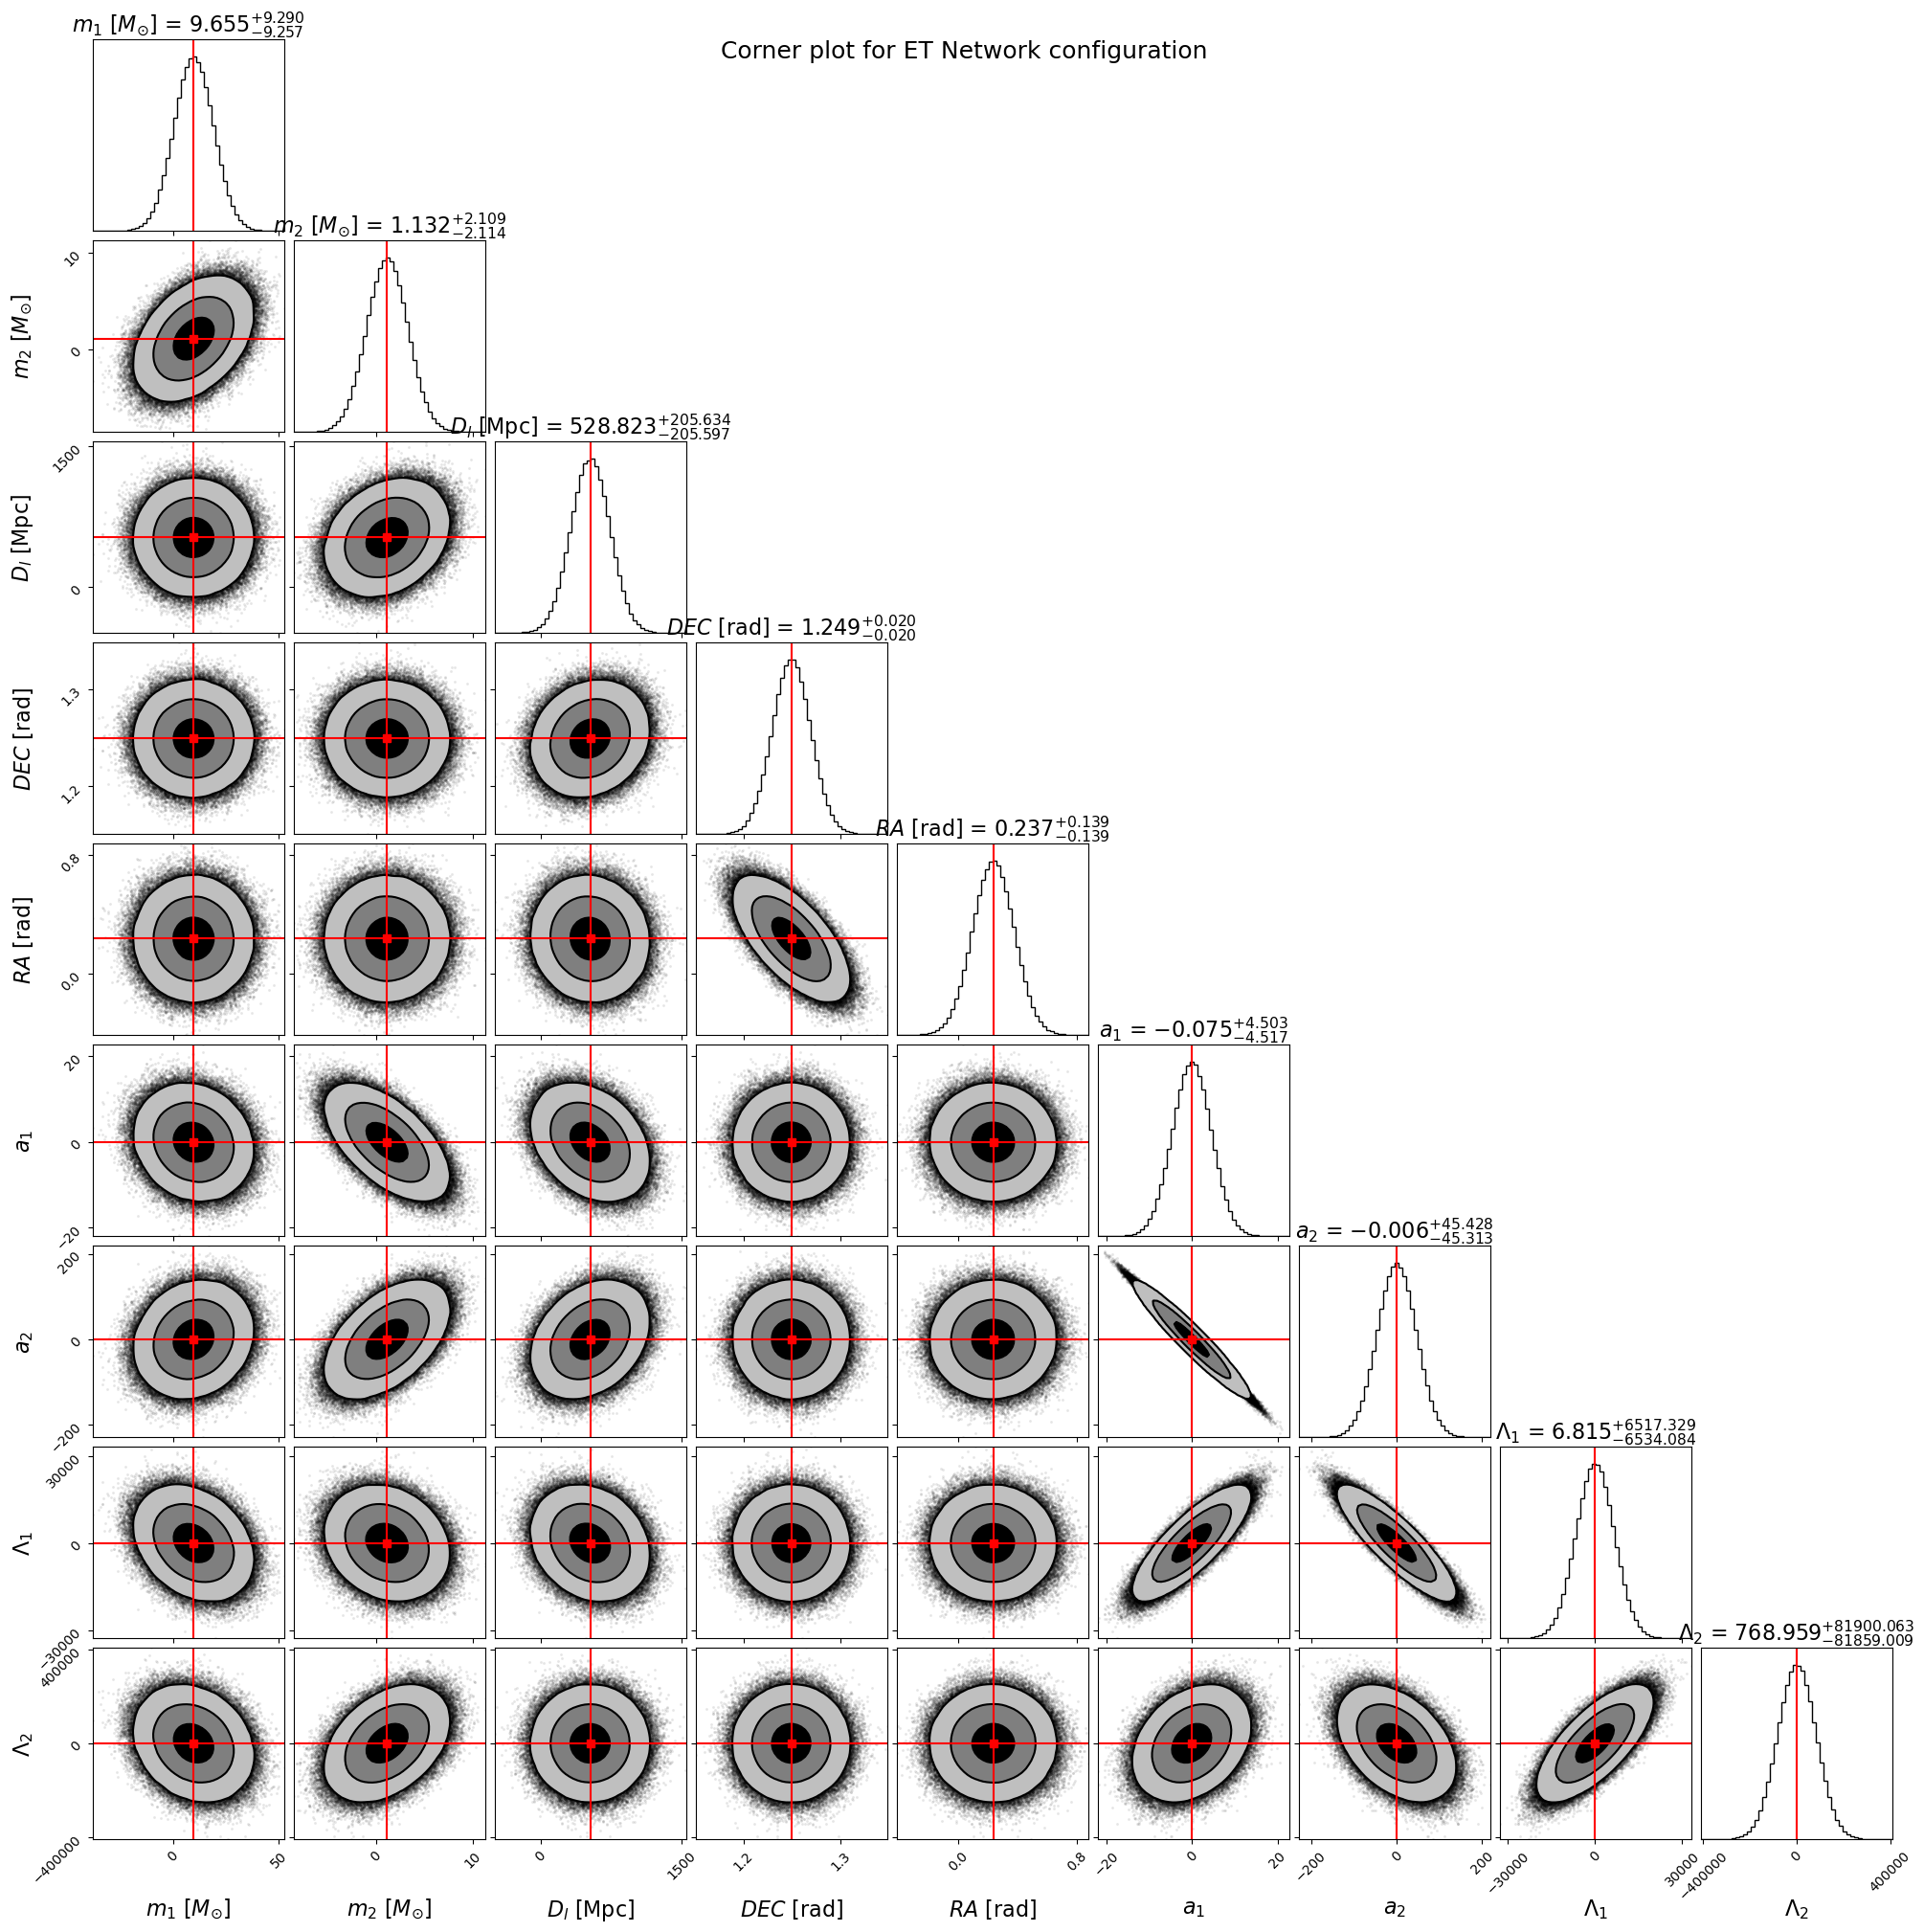

In [20]:
fig = corner.corner(samples_reduct, labels = corner_labels_reduct, truths = mean_values_reduct, truth_color = 'red', **CORNER_KWARGS)
fig.suptitle("Corner plot for L-V Network configuration",fontsize=18)
plt.show()

In [22]:
prior_cov_matrix_reduct= prior_cov_matrix[ index_list,:]
prior_cov_matrix_reduct=prior_cov_matrix_reduct[:,index_list]
print(len(prior_cov_matrix_reduct))

samples_prior_reduct = np.random.multivariate_normal(mean_values_reduct, prior_cov_matrix_reduct, int(1e6))

9


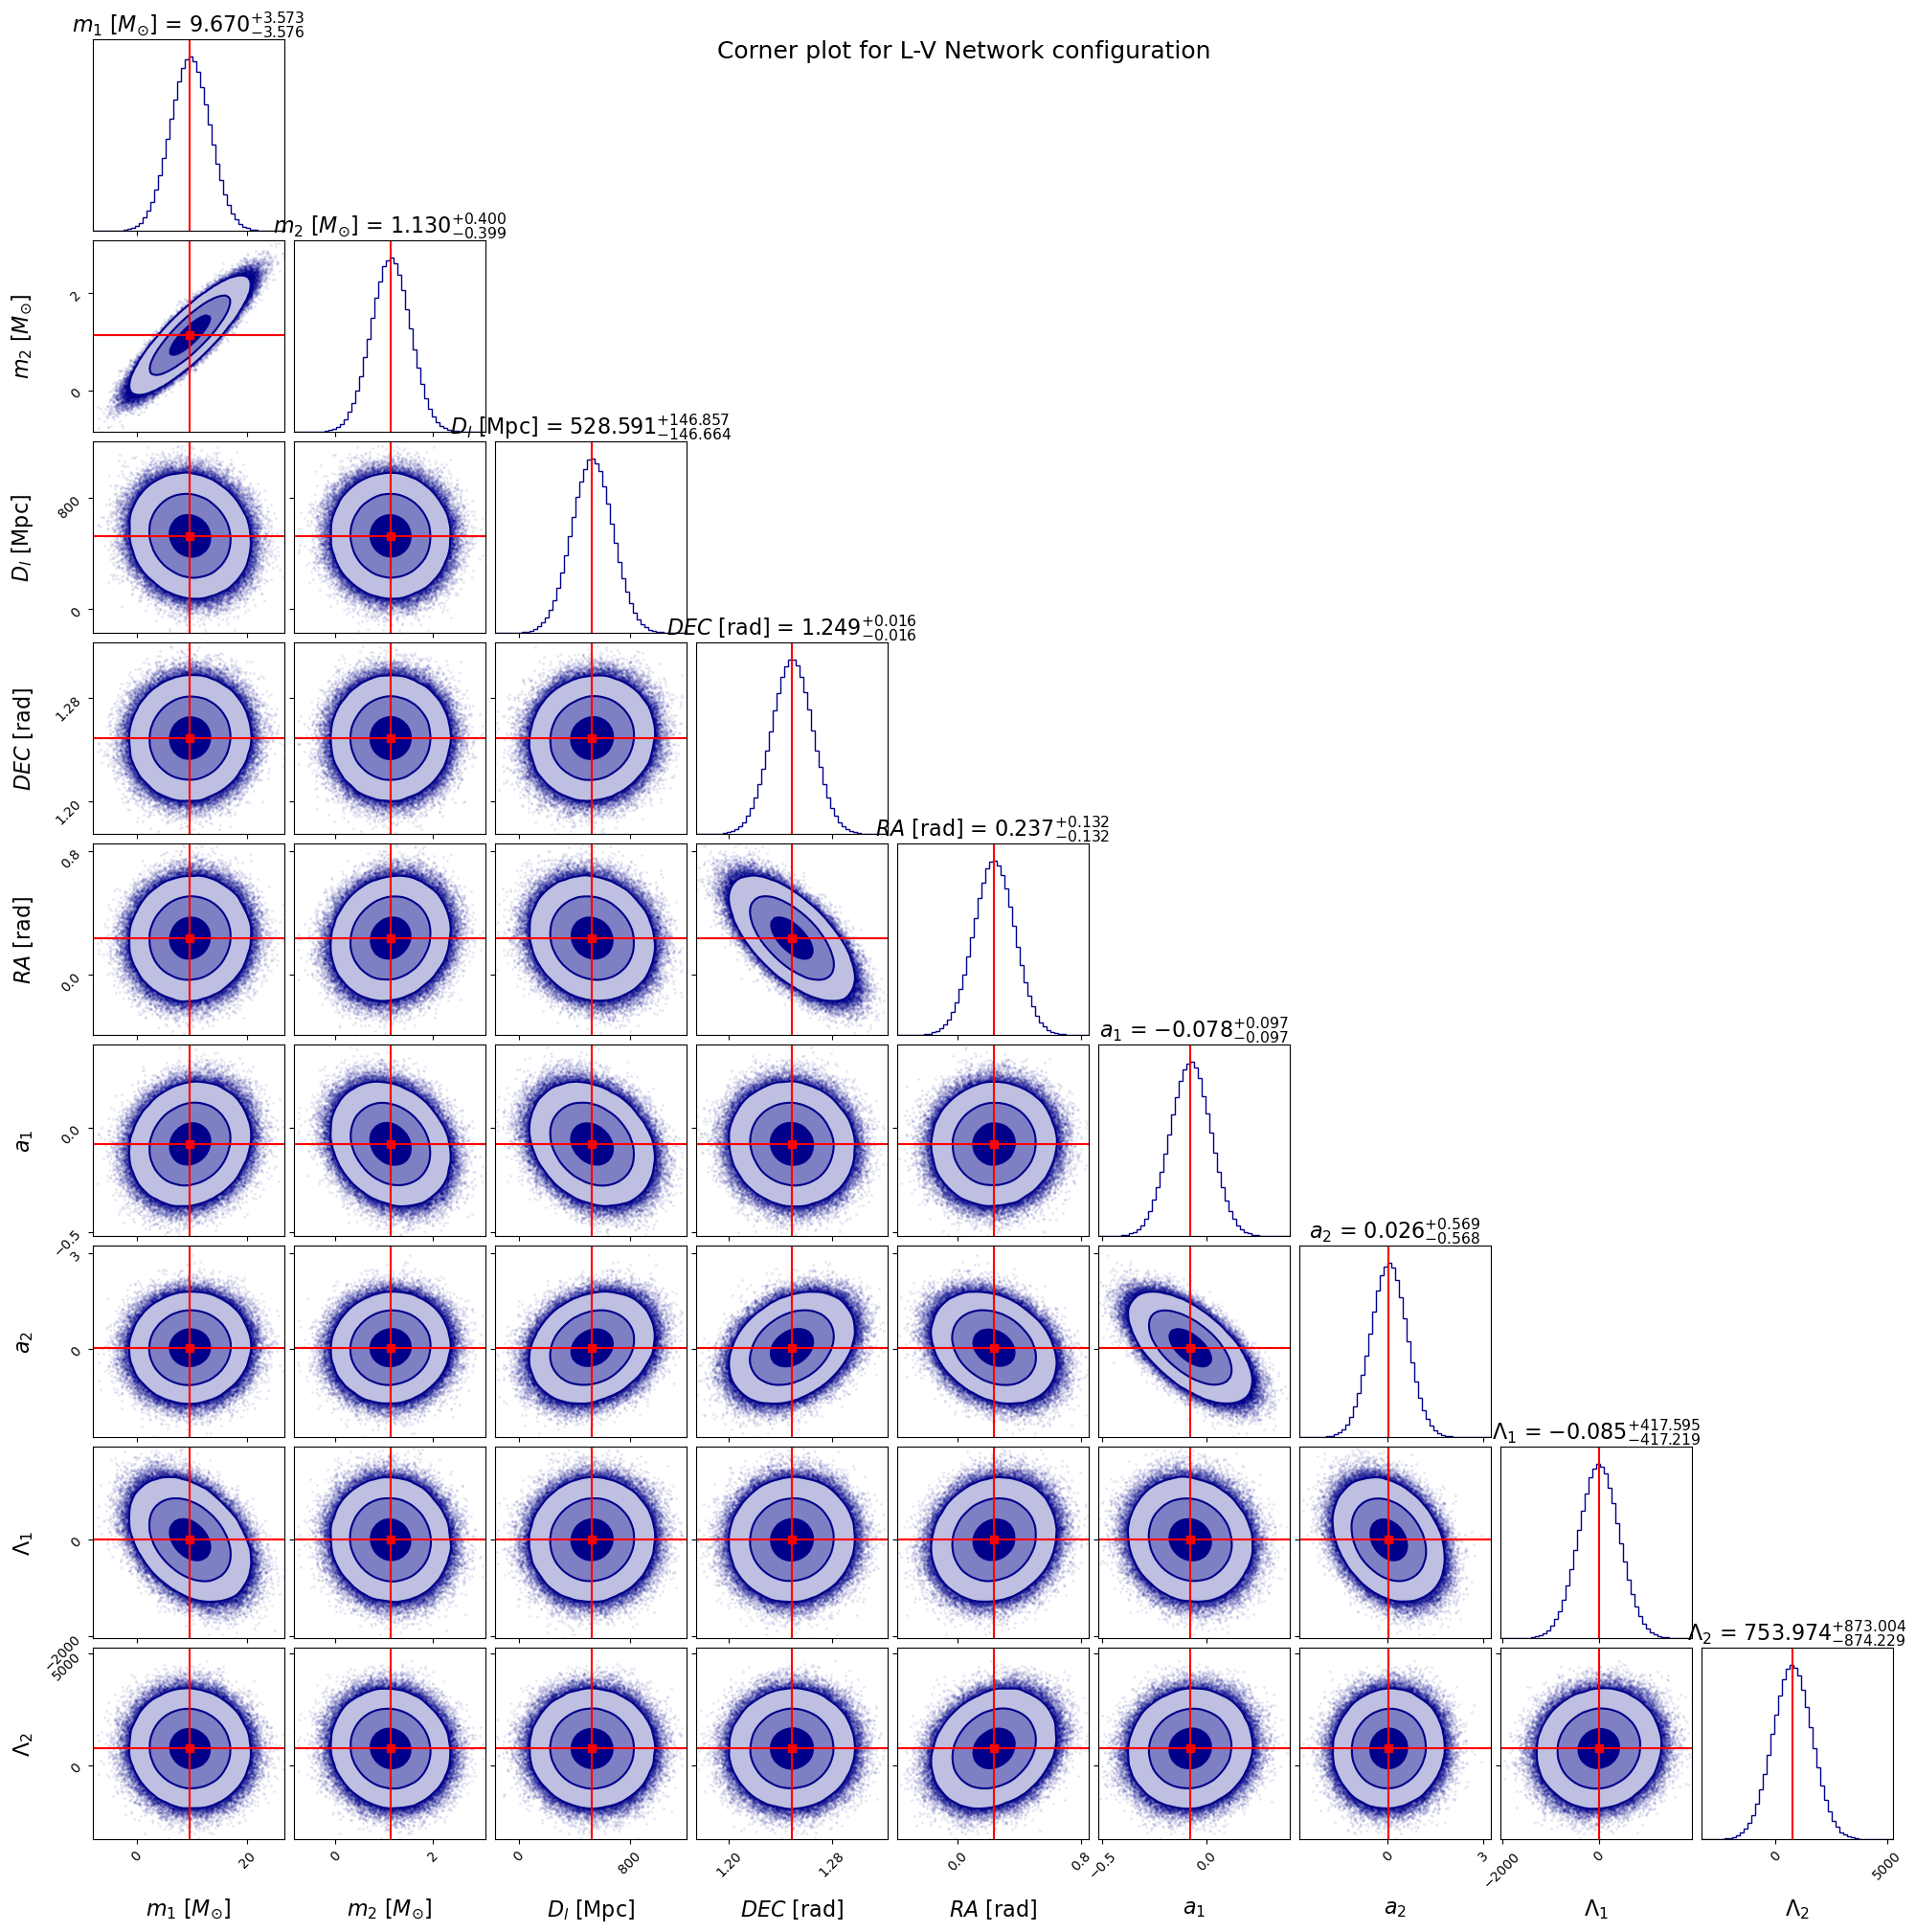

In [25]:
fig = corner.corner(samples_prior_reduct, labels = corner_labels_reduct, truths = mean_values_reduct, truth_color = 'red',color='darkblue',**CORNER_KWARGS)
fig.suptitle("Corner plot for L-V Network configuration",fontsize=18)
plt.show()

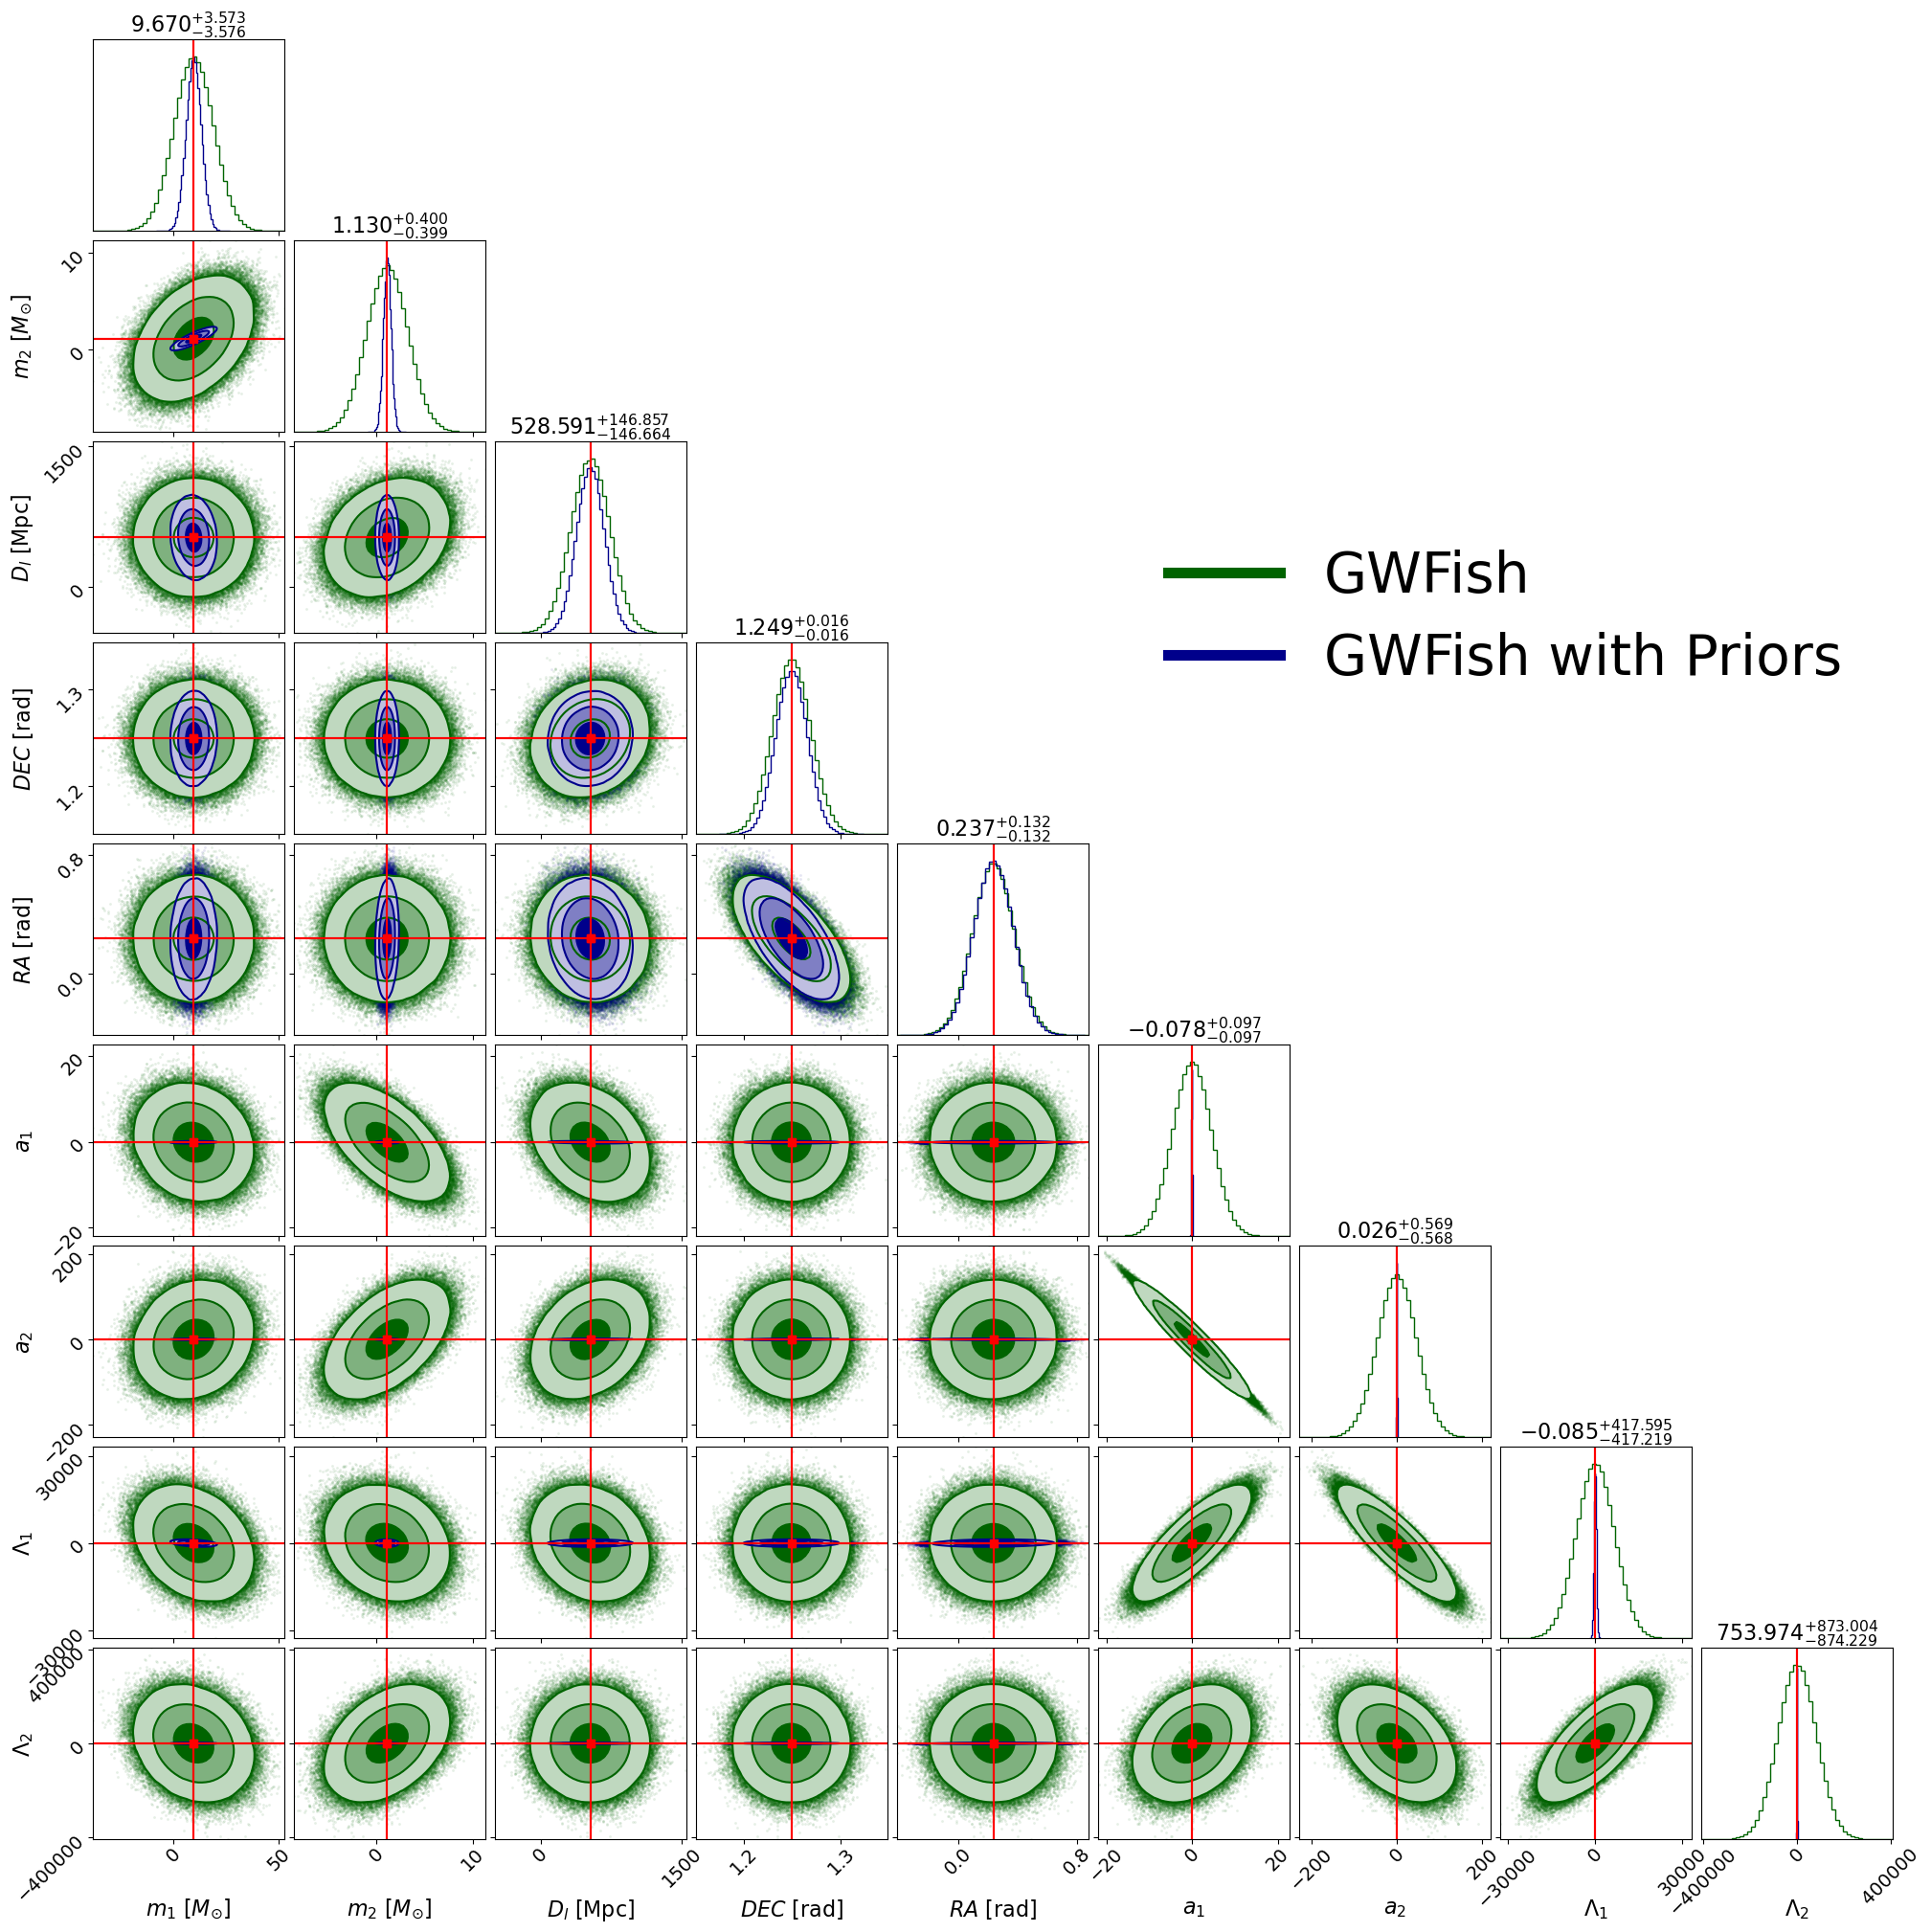

In [23]:
import matplotlib.lines as mlines

#colors= plt.colormaps['viridis'](np.linspace(0.6, 0.95, 2))

colors = ['darkgreen','darkblue']                          
sample_labels = ['GWFish', 'GWFish with Priors']


fig = corner.corner(samples_reduct, labels = corner_labels_reduct, truths = mean_values_reduct, truth_color = 'red', color=colors[0],**CORNER_KWARGS)
fig = corner.corner(samples_prior_reduct, fig = fig,  truths=mean_values_reduct, truth_color = 'red', color = colors[1], **CORNER_KWARGS)

#-------------------------------------------------------------------------------------------------------------------------------

for ax in fig.get_axes():
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14, pad = 0.1)

plt.legend(
        handles = [
            mlines.Line2D([], [], linewidth=8, color=colors[i], label = sample_labels[i])
            for i in range(2)
        ],
        fontsize = 42, frameon = False,
        bbox_to_anchor = (1, 7), loc = "upper right"
    )
plt.show()

## Tests
